# Tópicos em Especiais em Matemática Aplicada: Deep Learning

## Trabalho 03 - Conversão de Fórmulas Matemáticas Manuscritas para LaTeX

| Nome              | Matricula |
| ----------------- | --------- |
| Arthur José       | 190084600 |
| Eduardo Rodrigues | 190086521 |
| Kauã Vinícius     | 211029399 |

---

### Introdução

LaTeX é uma linguagem amplamente utilizada para a produção de documentos técnicos e acadêmicos de alta qualidade, especialmente aqueles que envolvem expressões matemáticas. No entanto, sua sintaxe baseada em comandos e caracteres especiais pode ser pouco intuitiva para o usuário comum, tornando a escrita de fórmulas complexas um processo demorado e sujeito a erros. Nesse contexto, torna-se relevante o desenvolvimento de uma rede neural capaz de interpretar expressões matemáticas manuscritas e convertê-las automaticamente em código LaTeX, facilitando a produção de conteúdo científico e ampliando a acessibilidade da linguagem.

---

### Metodologia

Para a realização da pesquisa, utilizou-se do método pesquisa-ação, tanto para o desenvolvimento do conteúdo, quanto para a construção das redes neurais presentes. O autor executava as redes neurais e, conforme a necessidade, modificava-as. Toda a pesquisa bibliográfica foi executada pelo Google Scholar, utilizando-se de strings de busca como:

| String de Busca           | Número de Resultados |
| ------------------------- | -------------------- |
| LaTeX AND Rede AND Neural | 4.460                |

Após buscas, pautadas na coesão dos resultados e viabilidade, chegou-se ao artigo _Watch, Attend and Parse: An End-to-End Neural Network Based Approach to Handwritten Mathematical Expression Recognition_, escrito por Zhang et al., 2017. O artigo sugere, para a resolução do problema, a utilização de uma arquitetura WAP(Watch, Attend and Parse).

---

### Arquitetura WAP (Watch, Attend and Parse)

A arquitetura **WAP** (Watch, Attend and Parse), proposta por Zhang et al. (2017), é um modelo de ponta a ponta dedicado ao reconhecimento de expressões matemáticas manuscritas. Ela é composta por três componentes principais:

#### **1. Watch (Observador / Encoder)**

Consiste em uma **Fully Convolutional Network (FCN)** responsável por extrair características da imagem da expressão matemática.  
O encoder transforma a imagem em um mapa de características rico, capturando padrões espaciais relevantes.

#### **2. Attend (Mecanismo de Atenção)**

Utiliza um **mecanismo de atenção baseado em cobertura** (_coverage-based attention_).  
Esse tipo de atenção reduz problemas comuns em decodificadores tradicionais, como:

- **over-parsing** (ler o mesmo símbolo mais de uma vez)
- **under-parsing** (pular símbolos importantes)

A cobertura mantém um histórico das regiões já atendidas, garantindo uma decodificação mais precisa.

#### **3. Parse (Parser / Decoder)**

É implementado com um **GRU** (Gated Recurrent Unit), responsável por gerar a sequência de saída em **LaTeX**.  
A cada passo, o decoder:

1. olha para o contexto fornecido pela atenção;
2. decide qual token LaTeX deve ser gerado;
3. atualiza seu estado e avança para o próximo símbolo.

---

### Formato da Entrada

O modelo WAP utiliza uma entrada composta por **9 canais**, conforme descrito no artigo:

- **Canal 0**: imagem em escala de cinza da fórmula manuscrita (renderizada ou capturada).
- **Canais 1–8**: representam imagens dos padrões de movimento do traço em **8 direções** diferentes.

Essas direções ajudam o modelo a entender **ordem e orientação do traço**, o que é essencial para distinguir símbolos manuscritos visualmente semelhantes, como:

- “1” e “l”
- “o” e “0”
- “–” e “=”
- operadores que dependem de inclinação ou estilo de escrita

Essas informações adicionais aumentam a robustez e precisão do reconhecimento.

---

### Implementação

Desta forma, o código foi implementado da seguinte forma:


#### Google Colab

Para o desenvolvimento do projeto, foi proposto inicialmente o armazenamento do dataset em um drive no google colab. Algo que devido as restrições de máquina do google colab não se manteve.


In [1]:
# # Montar Google Drive
# from google.colab import drive

# drive.mount("/content/drive")

# print("✓ Google Drive montado com sucesso!")


In [2]:
# # Instalar pacotes necessários
# !pip install -q -r /content/drive/MyDrive/Colab\ Notebooks/tema3/requirements.txt

# print("✓ Dependências instaladas com sucesso!")


In [3]:
# # Extrair dataset do zip
# !unzip -q /content/drive/MyDrive/Colab\ Notebooks/tema3/CROHME_all_9channel.zip

# print("✓ Dataset extraído com sucesso!")
# print("Localização do dataset: CROHME_all_9channel")


#### Imports e Variáveis Globais

Seguem as bibliotecas utilizadas e as respectivas variáveis globais do projeto.


In [1]:
import os
import json
from collections import Counter
from typing import List, Dict
import numpy as np
import pandas as pd
import editdistance

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# =============================================================================
# DATASET PATHS
# =============================================================================
DATA_DIR = "/home/ubuntu/tema3/dataset/CROHME_all_9channel"  # Dataset with 9-channel input
TRAIN_CSV = f"{DATA_DIR}/labels_train.csv"
TEST_CSV = f"{DATA_DIR}/labels_test.csv"

# =============================================================================
# SAVE PATHS (configurable)
# =============================================================================
VOCAB_PATH = "/home/ubuntu/tema3/dataset/vocab.json"  # Path to save vocabulary
BEST_MODEL_PATH = "/home/ubuntu/tema3/dataset/best_model.pth"  # Path to save best model

# =============================================================================
# DEVICE CONFIGURATION
# =============================================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# =============================================================================
# IMAGE SETTINGS
# =============================================================================
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_CHANNELS = 9  # 1 grayscale + 8 directional features (WAP paper spec)

# =============================================================================
# ENCODER ARCHITECTURE (FCN)
# =============================================================================
ENCODER_CHANNELS = [64, 128, 256, 512]  # Channels per block
ENCODER_BLOCKS = [4, 4, 4, 4]  # Conv layers per block
ENCODER_DROPOUT = 0.2  # Dropout rate (applied to last 4 conv layers, paper Section 6.1)
ENCODER_OUTPUT_DIM = 512  # Output dimension D

# =============================================================================
# DECODER ARCHITECTURE (GRU)
# =============================================================================
EMBEDDING_DIM = 256  # Token embedding dimension
HIDDEN_DIM = 256  # GRU hidden dimension
ATTENTION_DIM = 256  # Attention dimension

# =============================================================================
# ATTENTION MECHANISM
# =============================================================================
COVERAGE_KERNEL_SIZE = 11  # Kernel size for coverage convolution

# =============================================================================
# SEQUENCE SETTINGS
# =============================================================================
MAX_SEQ_LENGTH = 150  # Maximum sequence length (sequences longer will be filtered)

# =============================================================================
# TRAINING HYPERPARAMETERS
# =============================================================================
BATCH_SIZE = 64
NUM_EPOCHS = 200
# Optimizer: Adadelta (paper Section 6.1)
ADADELTA_LR = 1.0  # Adadelta default
ADADELTA_RHO = 0.95  # Decay rate
ADADELTA_EPS = 1e-6  # Epsilon
GRAD_CLIP = 5.0

# Validation interval
VAL_INTERVAL = 1

# =============================================================================
# INFERENCE SETTINGS
# =============================================================================
BEAM_SIZE = 10
VAL_BEAM_SIZE = 10

# =============================================================================
# VOCABULARY SETTINGS
# =============================================================================
MIN_TOKEN_FREQ = 1

# =============================================================================
# DATA LOADING
# =============================================================================
NUM_WORKERS = 4

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = False  # Speed > reproducibility
    torch.backends.cudnn.benchmark = True  # Enable autotuner
    print("✓ cuDNN optimizations enabled")

print("Configuration loaded successfully!")

Using device: cuda
✓ cuDNN optimizations enabled
Configuration loaded successfully!


#### Vocabulário

Por se tratar de um problema que envolve linguagem, deve-se definir um vocabulo. Desta forma, definiu-se a classe Vocabulary responsavel pela criação do mesmo. No construtor, defini-se inicialmente o token de pad, sos, eos e de unk. Posteriormente é definido-se os métodos inerentes à classe.


In [3]:
class Vocabulary:
    """Vocabulary for LaTeX mathematical expressions using character-level tokenization."""

    def __init__(self):
        self.pad_token = "<PAD>"
        self.sos_token = "<SOS>"
        self.eos_token = "</EOS>"
        self.unk_token = "<UNK>"
        self.token2id: Dict[str, int] = {}
        self.id2token: Dict[int, str] = {}
        self._init_special_tokens()

    def _init_special_tokens(self):
        special_tokens = [
            self.pad_token,
            self.sos_token,
            self.eos_token,
            self.unk_token,
        ]
        for idx, token in enumerate(special_tokens):
            self.token2id[token] = idx
            self.id2token[idx] = token

    def tokenize(self, latex_str: str) -> List[str]:
        """Tokenize LaTeX string using character-level tokenization."""
        return list(latex_str)

    def build_vocab(self, latex_strings: List[str], min_freq: int = 1):
        """Build vocabulary from LaTeX strings."""
        token_counter = Counter()
        for latex_str in latex_strings:
            token_counter.update(self.tokenize(latex_str))

        sorted_tokens = sorted(token_counter.items(), key=lambda x: (-x[1], x[0]))
        next_id = len(self.token2id)

        for token, freq in sorted_tokens:
            if freq >= min_freq and token not in self.token2id:
                self.token2id[token] = next_id
                self.id2token[next_id] = token
                next_id += 1

        print(f"Vocabulary built: {len(self.token2id)} tokens")

    def encode(self, latex_str: str, add_sos: bool = True, add_eos: bool = True) -> List[int]:
        """Encode LaTeX string to token IDs."""
        tokens = self.tokenize(latex_str)
        ids = []
        if add_sos:
            ids.append(self.token2id[self.sos_token])
        for token in tokens:
            ids.append(self.token2id.get(token, self.token2id[self.unk_token]))
        if add_eos:
            ids.append(self.token2id[self.eos_token])
        return ids

    def decode(self, token_ids: List[int], remove_special: bool = True) -> str:
        """Decode token IDs to LaTeX string."""
        tokens = []
        for idx in token_ids:
            token = self.id2token.get(idx, self.unk_token)
            if remove_special and token in [
                self.pad_token,
                self.sos_token,
                self.eos_token,
                self.unk_token,
            ]:
                continue
            tokens.append(token)
        return "".join(tokens)

    def __len__(self):
        return len(self.token2id)

    @property
    def pad_id(self):
        return self.token2id[self.pad_token]

    @property
    def sos_id(self):
        return self.token2id[self.sos_token]

    @property
    def eos_id(self):
        return self.token2id[self.eos_token]

    @property
    def unk_id(self):
        return self.token2id[self.unk_token]

#### Dataset

Na sequência, defini-se a classe CROHMEDataset, responspavel por desenvolver o dataset do chrome de modo a prepara-lo para o treinamento da inteligência artificial. Além disso, é necessário realizar a definição de uma função collate para que a IA possa retornar valores de tamanhos diferentes.


In [4]:
class CROHMEDataset(Dataset):
    """Dataset for CROHME handwritten mathematical expressions."""

    def __init__(self, csv_path: str, vocab: Vocabulary, max_seq_length: int = MAX_SEQ_LENGTH):
        self.vocab = vocab
        self.max_seq_length = max_seq_length
        self.df = pd.read_csv(csv_path)
        self.data_dir = os.path.dirname(csv_path)
        print(f"Loaded {len(self.df)} samples from {csv_path}")
        self._filter_long_sequences()

    def _filter_long_sequences(self):
        original_len = len(self.df)
        seq_lengths = []
        for latex in self.df["latex"]:
            tokens = self.vocab.tokenize(latex)
            seq_len = len(tokens) + 2
            seq_lengths.append(seq_len)
        self.df["seq_length"] = seq_lengths
        self.df = self.df[self.df["seq_length"] <= self.max_seq_length].copy()
        self.df = self.df.reset_index(drop=True)
        filtered = original_len - len(self.df)
        if filtered > 0:
            print(f"Filtered {filtered} samples with seq_length > {self.max_seq_length}")
            print(f"Remaining: {len(self.df)} samples")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.data_dir, row["image_path"])
        image = np.load(image_path)  # Shape: (9, 256, 256)
        image = torch.from_numpy(image).float()

        latex = row["latex"]
        target = self.vocab.encode(latex, add_sos=True, add_eos=True)
        target = torch.tensor(target, dtype=torch.long)
        target_length = len(target)

        return image, target, target_length


def collate_fn(batch):
    """Collate function for variable-length sequences."""
    images, targets, target_lengths = zip(*batch)
    images = torch.stack(images, dim=0)
    max_len = max(target_lengths)
    batch_size = len(targets)

    padded_targets = torch.full((batch_size, max_len), fill_value=0, dtype=torch.long)
    masks = torch.zeros((batch_size, max_len), dtype=torch.bool)

    for i, (target, length) in enumerate(zip(targets, target_lengths)):
        padded_targets[i, :length] = target
        masks[i, :length] = True

    return {
        "images": images,
        "targets": padded_targets,
        "target_lengths": torch.tensor(target_lengths, dtype=torch.long),
        "masks": masks,
    }

#### Arquitetura do modelo.

##### **1. Watch (Observador / Encoder)**

O componente _Watch_ corresponde ao **encoder** da arquitetura WAP, implementado como uma **Fully Convolutional Network (FCN)**. Seu papel é extrair representações visuais ricas da expressão matemática manuscrita, convertendo a imagem de entrada em um conjunto de vetores de características que serão posteriormente processados pelo mecanismo de atenção.

A implementação é construída a partir de dois elementos principais: o bloco convolucional (`ConvBlock`) e o encoder completo (`FCNEncoder`).

---

###### **ConvBlock**

O `ConvBlock` representa a unidade fundamental da rede convolucional. Ele aplica, em sequência:

1. **Convolução 2D** – para extração de padrões visuais locais.
2. **Batch Normalization** – para estabilizar e acelerar o treinamento.
3. **Função de ativação ReLU** – introduzindo não linearidade ao modelo.

Esse padrão (Conv → BatchNorm → ReLU) é amplamente utilizado em arquiteturas modernas por permitir que a rede aprenda representações mais robustas e expressivas. O bloco é definido da seguinte forma:

###### FCNEncoder

O FCNEncoder é composto por múltiplos blocos convolucionais empilhados, seguidos cada um por uma camada de MaxPooling, responsável por reduzir progressivamente a resolução espacial da imagem enquanto aumenta a profundidade do mapa de características. Essa estratégia permite que o modelo capture tanto detalhes locais (como pequenos símbolos) quanto estruturas mais amplas da expressão matemática.

O último bloco convolucional utiliza Dropout, conforme recomendado no artigo original, para reduzir overfitting e melhorar a generalização.

Ao final da passagem pelo encoder, o mapa de características resultante possui dimensão (B, D, H, W) — onde B é o batch, D é o número de canais, e H × W são as dimensões da imagem reduzida. Esse tensor é então linearizado e reorganizado para o formato sequencial (B, L, D), onde L = H × W. Essa conversão é essencial para que o decoder baseado em GRU possa processar a imagem como uma sequência de vetores.


In [5]:
class ConvBlock(nn.Module):
    """Convolutional block with Conv -> BatchNorm -> ReLU."""

    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=1,
            padding=kernel_size // 2,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


class FCNEncoder(nn.Module):
    """Fully Convolutional Network Encoder (Watcher)."""

    def __init__(self):
        super().__init__()
        self.encoder_blocks = nn.ModuleList()
        self.pool_layers = nn.ModuleList()

        current_channels = IMAGE_CHANNELS
        for block_idx, (out_channels, num_convs) in enumerate(zip(ENCODER_CHANNELS, ENCODER_BLOCKS)):
            block_layers = []
            for conv_idx in range(num_convs):
                if conv_idx == 0:
                    block_layers.append(ConvBlock(current_channels, out_channels))
                else:
                    block_layers.append(ConvBlock(out_channels, out_channels))

                # Apply dropout to last 4 conv layers (paper Section 6.1)
                # Last 4 conv layers = all 4 layers in the last block
                if block_idx == len(ENCODER_CHANNELS) - 1 and ENCODER_DROPOUT > 0:
                    block_layers.append(nn.Dropout2d(ENCODER_DROPOUT))

            self.encoder_blocks.append(nn.Sequential(*block_layers))
            self.pool_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            current_channels = out_channels

    def forward(self, x):
        """Input: (B, C, H, W) -> Output: (B, L, D) where L = H*W, D = 512"""
        for block, pool in zip(self.encoder_blocks, self.pool_layers):
            x = block(x)
            x = pool(x)

        B, D, H, W = x.shape
        x = x.view(B, D, H * W).permute(0, 2, 1)
        return x

##### **2. Attend (Mecanismo de Atenção)**

Utiliza um **mecanismo de atenção baseado em cobertura** (_coverage-based attention_).  
Esse tipo de atenção reduz problemas comuns em decodificadores tradicionais, como:

- **over-parsing** (ler o mesmo símbolo mais de uma vez)
- **under-parsing** (pular símbolos importantes)

A cobertura mantém um histórico das regiões já atendidas, garantindo uma decodificação mais precisa.


In [6]:
class CoverageAttention(nn.Module):
    """Coverage-based attention mechanism to prevent over/under-parsing."""

    def __init__(self):
        super().__init__()
        self.W_a = nn.Linear(HIDDEN_DIM, ATTENTION_DIM, bias=False)
        self.U_a = nn.Linear(ENCODER_OUTPUT_DIM, ATTENTION_DIM, bias=False)
        self.U_f = nn.Linear(ATTENTION_DIM, ATTENTION_DIM, bias=False)
        self.v_a = nn.Linear(ATTENTION_DIM, 1, bias=False)
        self.coverage_conv = nn.Conv1d(
            1,
            ATTENTION_DIM,
            kernel_size=COVERAGE_KERNEL_SIZE,
            padding=COVERAGE_KERNEL_SIZE // 2,
            bias=False,
        )

    def forward(self, hidden, annotations, coverage, mask=None):
        """
        Args:
            hidden: (B, n)
            annotations: (B, L, D)
            coverage: (B, L)
            mask: (B, L)
        Returns:
            context: (B, D)
            attention_weights: (B, L)
        """
        hidden_proj = self.W_a(hidden)
        annotations_proj = self.U_a(annotations)

        coverage_features = self.coverage_conv(coverage.unsqueeze(1))
        coverage_features = coverage_features.permute(0, 2, 1)
        coverage_proj = self.U_f(coverage_features)

        combined = torch.tanh(hidden_proj.unsqueeze(1) + annotations_proj + coverage_proj)
        energies = self.v_a(combined).squeeze(-1)

        if mask is not None:
            energies = energies.masked_fill(~mask, float("-inf"))

        attention_weights = F.softmax(energies, dim=1)
        context = torch.bmm(attention_weights.unsqueeze(1), annotations).squeeze(1)

        return context, attention_weights

##### **3. Parse (Parser / Decoder)**

É implementado com um **GRU** (Gated Recurrent Unit), responsável por gerar a sequência de saída em **LaTeX**.  
A cada passo, o decoder:

1. olha para o contexto fornecido pela atenção;
2. decide qual token LaTeX deve ser gerado;
3. atualiza seu estado e avança para o próximo símbolo.


In [7]:
class GRUDecoder(nn.Module):
    """GRU-based decoder with coverage attention (Parser)."""

    def __init__(self, vocab_size: int):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, EMBEDDING_DIM)
        self.attention = CoverageAttention()
        self.gru = nn.GRUCell(EMBEDDING_DIM + ENCODER_OUTPUT_DIM, HIDDEN_DIM)
        self.W_h = nn.Linear(HIDDEN_DIM, EMBEDDING_DIM)
        self.W_c = nn.Linear(ENCODER_OUTPUT_DIM, EMBEDDING_DIM)
        self.output_proj = nn.Linear(EMBEDDING_DIM, vocab_size)
        self.dropout = nn.Dropout(ENCODER_DROPOUT) if ENCODER_DROPOUT > 0 else None

    def forward_step(self, prev_token, hidden, annotations, coverage=None, annotation_mask=None):
        """Single decoding step."""
        embedded = self.embedding(prev_token)

        if coverage is None:
            batch_size, seq_len, _ = annotations.shape
            coverage = torch.zeros(batch_size, seq_len, device=annotations.device)

        context, attention_weights = self.attention(hidden, annotations, coverage, annotation_mask)
        coverage = coverage + attention_weights

        gru_input = torch.cat([embedded, context], dim=1)
        hidden = self.gru(gru_input, hidden)

        if self.dropout is not None:
            hidden = self.dropout(hidden)

        output = embedded + self.W_h(hidden) + self.W_c(context)
        logits = self.output_proj(output)

        return logits, hidden, attention_weights, coverage

    def forward(self, annotations, targets, target_lengths, annotation_mask=None):
        """Forward pass with teacher forcing."""
        batch_size, max_len = targets.shape
        seq_len = annotations.size(1)

        hidden = torch.zeros(batch_size, HIDDEN_DIM, device=annotations.device)
        coverage = torch.zeros(batch_size, seq_len, device=annotations.device)

        all_logits = []
        all_attention_weights = []

        for t in range(max_len - 1):
            prev_token = targets[:, t]
            logits, hidden, attention_weights, coverage = self.forward_step(
                prev_token, hidden, annotations, coverage, annotation_mask
            )
            all_logits.append(logits)
            all_attention_weights.append(attention_weights)

        logits = torch.stack(all_logits, dim=1)
        attention_weights = torch.stack(all_attention_weights, dim=1)

        return {"logits": logits, "attention_weights": attention_weights}

Na sequência, tem-se apenas a compilação das classes previamente acordadas.


In [8]:
class WAP(nn.Module):
    """WAP: Watch, Attend and Parse - End-to-end model."""

    def __init__(self, vocab_size: int):
        super().__init__()
        self.vocab_size = vocab_size
        self.encoder = FCNEncoder()
        self.decoder = GRUDecoder(vocab_size=vocab_size)

    def forward(self, images, targets=None, target_lengths=None):
        """Forward pass with teacher forcing for training."""
        annotations = self.encoder(images)

        if self.training and targets is not None:
            outputs = self.decoder(annotations, targets, target_lengths)
            return outputs
        else:
            raise NotImplementedError("Use beam_search() for inference")

    def beam_search(
        self,
        images,
        beam_size=BEAM_SIZE,
        max_length=MAX_SEQ_LENGTH,
        sos_id=1,
        eos_id=2,
        pad_id=0,
    ):
        """
        Performs vectorized beam search decoding for batch inference.

        All beams across all samples in the batch are processed in parallel,
        leveraging GPU parallelism for efficient inference.

        Args:
            images: Input images tensor (B, C, H, W)
            beam_size: Number of beams to keep at each step (K)
            max_length: Maximum sequence length to generate
            sos_id: Start-of-sequence token ID
            eos_id: End-of-sequence token ID
            pad_id: Padding token ID

        Returns:
            dict: Contains 'predictions' (best beam) and 'attention_weights' (None)
        """
        batch_size = images.size(0)
        device = images.device

        # 1. Extract visual features from input images using the encoder
        annotations = self.encoder(images)  # (B, L, D)
        seq_len = annotations.size(1)

        # 2. Replicate annotations for each beam to process all hypotheses in parallel
        # Shape: (B, K, L, D) -> (B*K, L, D) where K is beam_size
        # Each batch sample will have K copies for the K beams
        annotations_expanded = (
            annotations.unsqueeze(1)
            .expand(batch_size, beam_size, seq_len, -1)
            .reshape(batch_size * beam_size, seq_len, -1)
        )

        # 3. Initialize token sequences with padding
        # Shape: (B, K, max_length) - each batch item has K beams
        sequences = torch.full((batch_size, beam_size, max_length), pad_id, dtype=torch.long, device=device)
        sequences[:, :, 0] = sos_id  # Start all beams with SOS token

        # 4. Initialize beam scores (accumulated log-probabilities)
        # First beam starts with 0 (log(1) = 0), others with -inf to ensure single active beam initially
        beam_scores = torch.zeros(batch_size, beam_size, device=device)
        beam_scores[:, 1:] = -1e9

        # 5. Initialize decoder hidden states for all beams (B*K beams in total)
        hidden = torch.zeros(batch_size * beam_size, HIDDEN_DIM, device=device)

        # 6. Initialize attention coverage vectors to prevent over/under-parsing
        coverage = torch.zeros(batch_size * beam_size, seq_len, device=device)

        # 7. Track which beams have generated EOS token (finished)
        finished = torch.zeros(batch_size, beam_size, dtype=torch.bool, device=device)

        # 8. Autoregressive generation loop
        for t in range(1, max_length):
            # a. Extract previous tokens from all beams
            prev_tokens = sequences[:, :, t - 1].reshape(batch_size * beam_size)

            # b. Run decoder step for all (B*K) beams simultaneously
            logits, hidden, _, coverage = self.decoder.forward_step(prev_tokens, hidden, annotations_expanded, coverage)

            # c. Convert logits to log-probabilities
            log_probs = torch.log_softmax(logits, dim=-1)  # (B*K, V)

            # Reshape to separate batch and beam dimensions
            log_probs = log_probs.view(batch_size, beam_size, -1)  # (B, K, V)

            # d. Compute candidate scores for all possible next tokens
            # Add log-probabilities to beam scores (addition in log space = multiplication of probabilities)
            scores = beam_scores.unsqueeze(-1) + log_probs  # (B, K, V)

            # e. Mask finished beams: they should only emit EOS with unchanged score
            # For finished beams, set all token scores to -inf except EOS
            finished_mask = finished.unsqueeze(-1)  # (B, K, 1)

            # Create scores for finished beams: all -inf except EOS (maintains current score)
            scores_finished = torch.full_like(scores, -1e9)
            scores_finished[:, :, eos_id] = beam_scores  # beam_scores already has shape (B, K)

            # Apply mask: use scores_finished for finished beams, normal scores for active beams
            scores = torch.where(finished_mask, scores_finished, scores)

            # f. Flatten and select top-K global candidates from all (K * vocab_size) continuations
            scores_flat = scores.view(batch_size, -1)  # (B, K*V)
            top_scores, top_indices = scores_flat.topk(beam_size, dim=-1)  # (B, K)

            # g. Decode flattened indices back to (beam_index, token_index) pairs
            beam_indices = top_indices // self.vocab_size  # Which beam this came from
            token_indices = top_indices % self.vocab_size  # Which token to emit

            # h. Update beam scores with selected top-K scores
            beam_scores = top_scores

            # i. Reorder sequence history based on selected beams
            # FIX: Expand only up to t (current length) instead of max_length
            # This avoids accessing/modifying future uninitialized positions
            beam_indices_expanded = beam_indices.unsqueeze(-1).expand(batch_size, beam_size, t)
            sequences[:, :, :t] = torch.gather(sequences[:, :, :t], 1, beam_indices_expanded)

            # j. Append newly generated tokens to sequences
            sequences[:, :, t] = token_indices

            # k. Reorder finished flags to match selected beams
            finished = torch.gather(finished, 1, beam_indices)

            # l. Mark beams that just generated EOS as finished
            newly_finished = token_indices == eos_id
            finished = finished | newly_finished

            # m. Reorder hidden states to match selected beams
            # Shape: (B*K, D) -> (B, K, D) -> gather -> (B*K, D)
            hidden_reshaped = hidden.view(batch_size, beam_size, -1)
            beam_indices_hidden = beam_indices.unsqueeze(-1).expand(batch_size, beam_size, HIDDEN_DIM)
            hidden = torch.gather(hidden_reshaped, 1, beam_indices_hidden)
            hidden = hidden.reshape(batch_size * beam_size, -1)

            # n. Reorder coverage vectors to match selected beams
            # Shape: (B*K, L) -> (B, K, L) -> gather -> (B*K, L)
            coverage_reshaped = coverage.view(batch_size, beam_size, -1)
            beam_indices_coverage = beam_indices.unsqueeze(-1).expand(batch_size, beam_size, seq_len)
            coverage = torch.gather(coverage_reshaped, 1, beam_indices_coverage)
            coverage = coverage.reshape(batch_size * beam_size, -1)

            # o. Early stopping: terminate if all beams have generated EOS
            if finished.all():
                break

        # 9. Extract best hypothesis (highest scoring beam) for each batch sample
        # Beam 0 always has the highest score after reordering
        predictions = sequences[:, 0, :]  # (B, max_length)

        return {"predictions": predictions, "attention_weights": None}

##### Funções utilitárias

Para avaliar o desempenho do modelo, definem-se algumas funções responsáveis pelo cálculo das principais métricas. A primeira delas é `compute_wer`, que calcula o _Word Error Rate (WER)_. Essa métrica quantifica o quão diferente a sequência predita está da sequência verdadeira, utilizando como base a **distância de edição** (Levenshtein). Essa distância mede o número mínimo de operações necessárias para transformar uma sequência na outra, considerando inserções, remoções e substituições de tokens. Dessa forma, o WER fornece uma medida sensível ao nível de erro token por token, indicando quanto o modelo se afasta da expressão matemática correta.


In [9]:
def compute_wer(predictions, targets, pad_id=0):
    """Compute Word Error Rate."""
    total_words = 0
    total_distance = 0

    for pred, tgt in zip(predictions, targets):
        pred = [t for t in pred if t != pad_id]
        tgt = [t for t in tgt if t != pad_id]
        distance = editdistance.eval(pred, tgt)
        total_words += len(tgt)
        total_distance += distance

    wer = (total_distance / total_words * 100) if total_words > 0 else 0
    return {"wer": wer, "total_distance": total_distance, "total_words": total_words}


def compute_exprate(predictions, targets, pad_id=0):
    """Compute Expression Recognition Rate (exact match)."""
    correct = 0
    total = len(predictions)

    for pred, tgt in zip(predictions, targets):
        pred = [t for t in pred if t != pad_id]
        tgt = [t for t in tgt if t != pad_id]
        if pred == tgt:
            correct += 1

    return (correct / total * 100) if total > 0 else 0


def compute_metrics(predictions, targets, pad_id=0, sos_id=1, eos_id=2):
    """Compute all evaluation metrics."""

    def clean_sequence(seq):
        return [t for t in seq if t not in [pad_id, sos_id, eos_id]]

    clean_preds = [clean_sequence(pred) for pred in predictions]
    clean_targets = [clean_sequence(tgt) for tgt in targets]

    wer_metrics = compute_wer(clean_preds, clean_targets, pad_id)
    exprate = compute_exprate(clean_preds, clean_targets, pad_id)

    return {
        "exprate": exprate,
        "wer": wer_metrics["wer"],
        "total_distance": wer_metrics["total_distance"],
        "total_words": wer_metrics["total_words"],
    }


class AverageMeter:
    """Computes and stores the average and current value."""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

##### Treinamento

Dessa forma, o treinamento é realizado da seguinte maneira:


In [10]:
def train_epoch(model, dataloader, optimizer, criterion, device, epoch):
    """Train for one epoch."""
    model.train()
    losses = AverageMeter()
    pbar = tqdm(dataloader, desc=f"Epoch {epoch} [Train]")

    for batch in pbar:
        images = batch["images"].to(device)
        targets = batch["targets"].to(device)
        target_lengths = batch["target_lengths"].to(device)
        masks = batch["masks"].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images, targets, target_lengths)
        logits = outputs["logits"]

        B, T_minus_1, vocab_size = logits.shape
        logits_flat = logits.reshape(-1, vocab_size)
        targets_flat = targets[:, 1:].reshape(-1)
        mask_flat = masks[:, 1:].reshape(-1)

        loss = criterion(logits_flat, targets_flat)
        loss = (loss * mask_flat.float()).sum() / mask_flat.float().sum()

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()

        losses.update(loss.item(), images.size(0))
        pbar.set_postfix({"loss": losses.avg})

    return losses.avg


def validate(model, dataloader, criterion, device, vocab, epoch):
    """Validate model."""
    model.eval()
    losses = AverageMeter()
    all_predictions = []
    all_targets = []
    pbar = tqdm(dataloader, desc=f"Epoch {epoch} [Valid]")

    with torch.no_grad():
        for batch in pbar:
            images = batch["images"].to(device)
            targets = batch["targets"].to(device)
            target_lengths = batch["target_lengths"].to(device)
            masks = batch["masks"].to(device)

            # Compute loss with teacher forcing
            model.train()
            outputs = model(images, targets, target_lengths)
            model.eval()

            logits = outputs["logits"]
            B, T_minus_1, vocab_size = logits.shape
            logits_flat = logits.reshape(-1, vocab_size)
            targets_flat = targets[:, 1:].reshape(-1)
            mask_flat = masks[:, 1:].reshape(-1)

            loss = criterion(logits_flat, targets_flat)
            loss = (loss * mask_flat.float()).sum() / mask_flat.float().sum()
            losses.update(loss.item(), images.size(0))

            # Beam search for metrics
            pred_outputs = model.beam_search(
                images,
                beam_size=VAL_BEAM_SIZE,
                max_length=MAX_SEQ_LENGTH,
                sos_id=vocab.sos_id,
                eos_id=vocab.eos_id,
                pad_id=vocab.pad_id,
            )
            predictions = pred_outputs["predictions"]

            all_predictions.extend(predictions.cpu().tolist())
            all_targets.extend(targets.cpu().tolist())
            pbar.set_postfix({"loss": losses.avg})

    metrics = compute_metrics(all_predictions, all_targets, vocab.pad_id, vocab.sos_id, vocab.eos_id)
    metrics["loss"] = losses.avg

    return metrics

É realizado a construção do vocabulário


In [11]:
# Build vocabulary from training data
print("Building vocabulary...")
train_df = pd.read_csv(TRAIN_CSV)
latex_strings = train_df["latex"].tolist()

vocab = Vocabulary()
vocab.build_vocab(latex_strings, min_freq=MIN_TOKEN_FREQ)

print(f"\nVocabulary size: {len(vocab)}")
print(f"PAD ID: {vocab.pad_id}, SOS ID: {vocab.sos_id}, EOS ID: {vocab.eos_id}")

vocab_dict = {
    "token2id": vocab.token2id,
    "id2token": {int(k): v for k, v in vocab.id2token.items()},  # JSON requires string keys
    "special_tokens": {
        "pad_token": vocab.pad_token,
        "sos_token": vocab.sos_token,
        "eos_token": vocab.eos_token,
        "unk_token": vocab.unk_token,
    },
}

with open(VOCAB_PATH, "w") as f:
    json.dump(vocab_dict, f, indent=2)

print(f"✓ Vocabulary saved to {VOCAB_PATH}")

Building vocabulary...
Vocabulary built: 84 tokens

Vocabulary size: 84
PAD ID: 0, SOS ID: 1, EOS ID: 2
✓ Vocabulary saved to /home/ubuntu/tema3/dataset/vocab.json


Criado os dataloaders


In [12]:
print("Creating datasets...")
train_dataset = CROHMEDataset(csv_path=TRAIN_CSV, vocab=vocab, max_seq_length=MAX_SEQ_LENGTH)
test_dataset = CROHMEDataset(csv_path=TEST_CSV, vocab=vocab, max_seq_length=MAX_SEQ_LENGTH)

print("\nCreating dataloaders...")
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True,
)

print(f"Train: {len(train_dataset)} samples, {len(train_loader)} batches")
print(f"Test: {len(test_dataset)} samples, {len(test_loader)} batches")

Creating datasets...
Loaded 13259 samples from /home/ubuntu/tema3/dataset/CROHME_all_9channel/labels_train.csv
Filtered 3 samples with seq_length > 150
Remaining: 13256 samples
Loaded 1474 samples from /home/ubuntu/tema3/dataset/CROHME_all_9channel/labels_test.csv

Creating dataloaders...
Train: 13256 samples, 208 batches
Test: 1474 samples, 24 batches


E por fim, treinado o modelo


In [13]:
print("Creating model...")
device = torch.device(DEVICE)
model = WAP(vocab_size=len(vocab))
model = model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {num_params:,}")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(reduction="none")
optimizer = optim.Adadelta(
    model.parameters(),
    lr=ADADELTA_LR,
    rho=ADADELTA_RHO,
    eps=ADADELTA_EPS,
)

print("Model initialized successfully!")

Creating model...
Total trainable parameters: 12,258,708
Model initialized successfully!


In [17]:
print("=" * 70)
print("Starting training...")
print("=" * 70)

best_wer = float("inf")
best_epoch = 0

# Lists to store metrics for plotting
train_losses = []
val_losses = []
val_wers = []
val_exprates = []
val_epochs = []

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}")
    print("-" * 70)

    # Train
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, epoch)
    print(f"Train Loss: {train_loss:.4f}")
    train_losses.append(train_loss)

    # Validate every VAL_INTERVAL epochs
    if epoch % VAL_INTERVAL == 0:
        val_metrics = validate(model, test_loader, criterion, device, vocab, epoch)
        print(f"Val Loss: {val_metrics['loss']:.4f}")
        print(f"Val WER: {val_metrics['wer']:.2f}%")
        print(f"Val ExpRate: {val_metrics['exprate']:.2f}%")

        # Append to lists
        val_losses.append(val_metrics["loss"])
        val_wers.append(val_metrics["wer"])
        val_exprates.append(val_metrics["exprate"])
        val_epochs.append(epoch)

        # Check for improvement (lower WER is better)
        current_wer = val_metrics["wer"]
        is_best = current_wer < best_wer

        if is_best:
            best_wer = current_wer
            best_epoch = epoch

            # Save best model checkpoint
            checkpoint = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_wer": best_wer,
                "vocab_size": len(vocab),
                "val_metrics": val_metrics,
            }
            torch.save(checkpoint, BEST_MODEL_PATH)
            print(f"✓ New best model saved! (WER={best_wer:.4f})")

print("\n" + "=" * 70)
print("Training Complete!")
print("=" * 70)
print(f"Best WER: {best_wer:.4f} at epoch {best_epoch}")

Starting training...

Epoch 1/200
----------------------------------------------------------------------


Epoch 1 [Train]: 100%|██████████| 208/208 [02:27<00:00,  1.41it/s, loss=1.96]


Train Loss: 1.9621


Epoch 1 [Valid]: 100%|██████████| 24/24 [00:37<00:00,  1.56s/it, loss=1.75]


Val Loss: 1.7533
Val WER: 93.93%
Val ExpRate: 0.00%
✓ New best model saved! (WER=93.9308)

Epoch 2/200
----------------------------------------------------------------------


Epoch 2 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.58it/s, loss=1.55]


Train Loss: 1.5522


Epoch 2 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.28s/it, loss=1.64]


Val Loss: 1.6361
Val WER: 92.99%
Val ExpRate: 0.00%
✓ New best model saved! (WER=92.9897)

Epoch 3/200
----------------------------------------------------------------------


Epoch 3 [Train]: 100%|██████████| 208/208 [02:12<00:00,  1.57it/s, loss=1.42]


Train Loss: 1.4187


Epoch 3 [Valid]: 100%|██████████| 24/24 [00:31<00:00,  1.29s/it, loss=1.56]


Val Loss: 1.5586
Val WER: 242.52%
Val ExpRate: 0.00%

Epoch 4/200
----------------------------------------------------------------------


Epoch 4 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=1.33]


Train Loss: 1.3328


Epoch 4 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.28s/it, loss=1.41]


Val Loss: 1.4071
Val WER: 155.95%
Val ExpRate: 0.00%

Epoch 5/200
----------------------------------------------------------------------


Epoch 5 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=1.27]


Train Loss: 1.2669


Epoch 5 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.13s/it, loss=1.42]


Val Loss: 1.4191
Val WER: 87.91%
Val ExpRate: 0.00%
✓ New best model saved! (WER=87.9130)

Epoch 6/200
----------------------------------------------------------------------


Epoch 6 [Train]: 100%|██████████| 208/208 [02:12<00:00,  1.57it/s, loss=1.22]


Train Loss: 1.2174


Epoch 6 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.29s/it, loss=1.32]


Val Loss: 1.3159
Val WER: 86.32%
Val ExpRate: 0.07%
✓ New best model saved! (WER=86.3214)

Epoch 7/200
----------------------------------------------------------------------


Epoch 7 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=1.18]


Train Loss: 1.1755


Epoch 7 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.27s/it, loss=1.37]


Val Loss: 1.3725
Val WER: 87.49%
Val ExpRate: 0.41%

Epoch 8/200
----------------------------------------------------------------------


Epoch 8 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=1.14]


Train Loss: 1.1431


Epoch 8 [Valid]: 100%|██████████| 24/24 [00:26<00:00,  1.12s/it, loss=1.57]


Val Loss: 1.5725
Val WER: 93.73%
Val ExpRate: 0.00%

Epoch 9/200
----------------------------------------------------------------------


Epoch 9 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.58it/s, loss=1.12]


Train Loss: 1.1154


Epoch 9 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.29s/it, loss=1.27]


Val Loss: 1.2691
Val WER: 84.29%
Val ExpRate: 1.09%
✓ New best model saved! (WER=84.2916)

Epoch 10/200
----------------------------------------------------------------------


Epoch 10 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.58it/s, loss=1.09]


Train Loss: 1.0861


Epoch 10 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.27s/it, loss=1.18]


Val Loss: 1.1794
Val WER: 164.66%
Val ExpRate: 0.61%

Epoch 11/200
----------------------------------------------------------------------


Epoch 11 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=1.06]


Train Loss: 1.0619


Epoch 11 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.29s/it, loss=1.21]


Val Loss: 1.2088
Val WER: 97.11%
Val ExpRate: 0.07%

Epoch 12/200
----------------------------------------------------------------------


Epoch 12 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.61it/s, loss=1.04]


Train Loss: 1.0388


Epoch 12 [Valid]: 100%|██████████| 24/24 [00:31<00:00,  1.30s/it, loss=1.13]


Val Loss: 1.1289
Val WER: 76.98%
Val ExpRate: 0.95%
✓ New best model saved! (WER=76.9750)

Epoch 13/200
----------------------------------------------------------------------


Epoch 13 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=1.02]


Train Loss: 1.0241


Epoch 13 [Valid]: 100%|██████████| 24/24 [00:31<00:00,  1.29s/it, loss=1.18]


Val Loss: 1.1769
Val WER: 92.38%
Val ExpRate: 0.81%

Epoch 14/200
----------------------------------------------------------------------


Epoch 14 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.58it/s, loss=1]    


Train Loss: 1.0014


Epoch 14 [Valid]: 100%|██████████| 24/24 [00:31<00:00,  1.31s/it, loss=1.14]


Val Loss: 1.1432
Val WER: 84.52%
Val ExpRate: 0.47%

Epoch 15/200
----------------------------------------------------------------------


Epoch 15 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.58it/s, loss=0.98] 


Train Loss: 0.9801


Epoch 15 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.25s/it, loss=1.12]


Val Loss: 1.1238
Val WER: 79.76%
Val ExpRate: 1.36%

Epoch 16/200
----------------------------------------------------------------------


Epoch 16 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.965]


Train Loss: 0.9647


Epoch 16 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.29s/it, loss=1.23]


Val Loss: 1.2272
Val WER: 82.39%
Val ExpRate: 0.95%

Epoch 17/200
----------------------------------------------------------------------


Epoch 17 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.948]


Train Loss: 0.9476


Epoch 17 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.28s/it, loss=1.06]


Val Loss: 1.0625
Val WER: 98.81%
Val ExpRate: 5.16%

Epoch 18/200
----------------------------------------------------------------------


Epoch 18 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.60it/s, loss=0.925]


Train Loss: 0.9250


Epoch 18 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.28s/it, loss=1.18]


Val Loss: 1.1769
Val WER: 96.16%
Val ExpRate: 3.05%

Epoch 19/200
----------------------------------------------------------------------


Epoch 19 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.915]


Train Loss: 0.9150


Epoch 19 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.28s/it, loss=1.12]


Val Loss: 1.1218
Val WER: 113.03%
Val ExpRate: 0.20%

Epoch 20/200
----------------------------------------------------------------------


Epoch 20 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.896]


Train Loss: 0.8964


Epoch 20 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.20s/it, loss=1.15]


Val Loss: 1.1526
Val WER: 79.92%
Val ExpRate: 1.15%

Epoch 21/200
----------------------------------------------------------------------


Epoch 21 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.879]


Train Loss: 0.8788


Epoch 21 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.29s/it, loss=1.04]


Val Loss: 1.0371
Val WER: 70.57%
Val ExpRate: 4.82%
✓ New best model saved! (WER=70.5727)

Epoch 22/200
----------------------------------------------------------------------


Epoch 22 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.58it/s, loss=0.862]


Train Loss: 0.8621


Epoch 22 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.28s/it, loss=1.09]


Val Loss: 1.0935
Val WER: 79.53%
Val ExpRate: 1.09%

Epoch 23/200
----------------------------------------------------------------------


Epoch 23 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.843]


Train Loss: 0.8430


Epoch 23 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.28s/it, loss=1.08]


Val Loss: 1.0849
Val WER: 144.91%
Val ExpRate: 6.04%

Epoch 24/200
----------------------------------------------------------------------


Epoch 24 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.836]


Train Loss: 0.8364


Epoch 24 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.29s/it, loss=0.995]


Val Loss: 0.9949
Val WER: 70.93%
Val ExpRate: 5.16%

Epoch 25/200
----------------------------------------------------------------------


Epoch 25 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.823]


Train Loss: 0.8233


Epoch 25 [Valid]: 100%|██████████| 24/24 [00:31<00:00,  1.30s/it, loss=1.01] 


Val Loss: 1.0114
Val WER: 67.57%
Val ExpRate: 8.48%
✓ New best model saved! (WER=67.5683)

Epoch 26/200
----------------------------------------------------------------------


Epoch 26 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.792]


Train Loss: 0.7923


Epoch 26 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.28s/it, loss=0.922]


Val Loss: 0.9216
Val WER: 77.34%
Val ExpRate: 10.58%

Epoch 27/200
----------------------------------------------------------------------


Epoch 27 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.772]


Train Loss: 0.7724


Epoch 27 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.27s/it, loss=0.888]


Val Loss: 0.8880
Val WER: 65.71%
Val ExpRate: 9.02%
✓ New best model saved! (WER=65.7084)

Epoch 28/200
----------------------------------------------------------------------


Epoch 28 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.58it/s, loss=0.752]


Train Loss: 0.7523


Epoch 28 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.28s/it, loss=1.04]


Val Loss: 1.0361
Val WER: 86.58%
Val ExpRate: 3.26%

Epoch 29/200
----------------------------------------------------------------------


Epoch 29 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.736]


Train Loss: 0.7361


Epoch 29 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it, loss=0.934]


Val Loss: 0.9338
Val WER: 70.39%
Val ExpRate: 3.53%

Epoch 30/200
----------------------------------------------------------------------


Epoch 30 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.714]


Train Loss: 0.7140


Epoch 30 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.25s/it, loss=0.942]


Val Loss: 0.9417
Val WER: 61.18%
Val ExpRate: 5.29%
✓ New best model saved! (WER=61.1772)

Epoch 31/200
----------------------------------------------------------------------


Epoch 31 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.693]


Train Loss: 0.6930


Epoch 31 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.28s/it, loss=1.19]


Val Loss: 1.1875
Val WER: 109.93%
Val ExpRate: 1.36%

Epoch 32/200
----------------------------------------------------------------------


Epoch 32 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.672]


Train Loss: 0.6718


Epoch 32 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it, loss=1.04]


Val Loss: 1.0373
Val WER: 74.45%
Val ExpRate: 1.29%

Epoch 33/200
----------------------------------------------------------------------


Epoch 33 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.646]


Train Loss: 0.6460


Epoch 33 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.28s/it, loss=0.785]


Val Loss: 0.7854
Val WER: 57.12%
Val ExpRate: 10.85%
✓ New best model saved! (WER=57.1199)

Epoch 34/200
----------------------------------------------------------------------


Epoch 34 [Train]: 100%|██████████| 208/208 [02:12<00:00,  1.57it/s, loss=0.624]


Train Loss: 0.6238


Epoch 34 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.25s/it, loss=0.846]


Val Loss: 0.8458
Val WER: 59.30%
Val ExpRate: 6.92%

Epoch 35/200
----------------------------------------------------------------------


Epoch 35 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.608]


Train Loss: 0.6077


Epoch 35 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it, loss=0.871]


Val Loss: 0.8709
Val WER: 66.60%
Val ExpRate: 6.38%

Epoch 36/200
----------------------------------------------------------------------


Epoch 36 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.577]


Train Loss: 0.5768


Epoch 36 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.29s/it, loss=0.82] 


Val Loss: 0.8197
Val WER: 72.34%
Val ExpRate: 11.80%

Epoch 37/200
----------------------------------------------------------------------


Epoch 37 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.556]


Train Loss: 0.5561


Epoch 37 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.26s/it, loss=0.801]


Val Loss: 0.8014
Val WER: 59.59%
Val ExpRate: 10.72%

Epoch 38/200
----------------------------------------------------------------------


Epoch 38 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.541]


Train Loss: 0.5405


Epoch 38 [Valid]: 100%|██████████| 24/24 [00:31<00:00,  1.30s/it, loss=0.776]


Val Loss: 0.7763
Val WER: 131.86%
Val ExpRate: 10.99%

Epoch 39/200
----------------------------------------------------------------------


Epoch 39 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.515]


Train Loss: 0.5152


Epoch 39 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.29s/it, loss=0.682]


Val Loss: 0.6818
Val WER: 49.05%
Val ExpRate: 14.38%
✓ New best model saved! (WER=49.0455)

Epoch 40/200
----------------------------------------------------------------------


Epoch 40 [Train]: 100%|██████████| 208/208 [02:12<00:00,  1.57it/s, loss=0.498]


Train Loss: 0.4984


Epoch 40 [Valid]: 100%|██████████| 24/24 [00:31<00:00,  1.31s/it, loss=0.783]


Val Loss: 0.7835
Val WER: 83.24%
Val ExpRate: 11.40%

Epoch 41/200
----------------------------------------------------------------------


Epoch 41 [Train]: 100%|██████████| 208/208 [02:12<00:00,  1.58it/s, loss=0.474]


Train Loss: 0.4744


Epoch 41 [Valid]: 100%|██████████| 24/24 [00:31<00:00,  1.31s/it, loss=1.08]


Val Loss: 1.0786
Val WER: 109.31%
Val ExpRate: 5.56%

Epoch 42/200
----------------------------------------------------------------------


Epoch 42 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.472]


Train Loss: 0.4722


Epoch 42 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.29s/it, loss=1.22]


Val Loss: 1.2192
Val WER: 142.22%
Val ExpRate: 0.61%

Epoch 43/200
----------------------------------------------------------------------


Epoch 43 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.46] 


Train Loss: 0.4599


Epoch 43 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=1.08]


Val Loss: 1.0846
Val WER: 69.73%
Val ExpRate: 0.75%

Epoch 44/200
----------------------------------------------------------------------


Epoch 44 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.435]


Train Loss: 0.4347


Epoch 44 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.29s/it, loss=0.979]


Val Loss: 0.9787
Val WER: 71.84%
Val ExpRate: 5.29%

Epoch 45/200
----------------------------------------------------------------------


Epoch 45 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.432]


Train Loss: 0.4317


Epoch 45 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.29s/it, loss=0.888]


Val Loss: 0.8878
Val WER: 101.22%
Val ExpRate: 4.55%

Epoch 46/200
----------------------------------------------------------------------


Epoch 46 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.408]


Train Loss: 0.4081


Epoch 46 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it, loss=1.12]


Val Loss: 1.1243
Val WER: 74.47%
Val ExpRate: 2.04%

Epoch 47/200
----------------------------------------------------------------------


Epoch 47 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.419]


Train Loss: 0.4186


Epoch 47 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.28s/it, loss=0.549]


Val Loss: 0.5494
Val WER: 31.09%
Val ExpRate: 26.87%
✓ New best model saved! (WER=31.0927)

Epoch 48/200
----------------------------------------------------------------------


Epoch 48 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.58it/s, loss=0.389]


Train Loss: 0.3894


Epoch 48 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.20s/it, loss=1.07]


Val Loss: 1.0651
Val WER: 70.79%
Val ExpRate: 6.45%

Epoch 49/200
----------------------------------------------------------------------


Epoch 49 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.383]


Train Loss: 0.3832


Epoch 49 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.25s/it, loss=0.54] 


Val Loss: 0.5399
Val WER: 34.16%
Val ExpRate: 26.59%

Epoch 50/200
----------------------------------------------------------------------


Epoch 50 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.60it/s, loss=0.368]


Train Loss: 0.3677


Epoch 50 [Valid]: 100%|██████████| 24/24 [00:31<00:00,  1.30s/it, loss=0.594]


Val Loss: 0.5941
Val WER: 41.55%
Val ExpRate: 23.27%

Epoch 51/200
----------------------------------------------------------------------


Epoch 51 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.359]


Train Loss: 0.3586


Epoch 51 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.27s/it, loss=0.559]


Val Loss: 0.5589
Val WER: 43.71%
Val ExpRate: 20.22%

Epoch 52/200
----------------------------------------------------------------------


Epoch 52 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.61it/s, loss=0.339]


Train Loss: 0.3390


Epoch 52 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it, loss=0.477]


Val Loss: 0.4773
Val WER: 31.09%
Val ExpRate: 27.88%
✓ New best model saved! (WER=31.0904)

Epoch 53/200
----------------------------------------------------------------------


Epoch 53 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.331]


Train Loss: 0.3311


Epoch 53 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=0.753]


Val Loss: 0.7528
Val WER: 46.36%
Val ExpRate: 8.41%

Epoch 54/200
----------------------------------------------------------------------


Epoch 54 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.34] 


Train Loss: 0.3403


Epoch 54 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.27s/it, loss=0.448]


Val Loss: 0.4484
Val WER: 31.49%
Val ExpRate: 34.19%

Epoch 55/200
----------------------------------------------------------------------


Epoch 55 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.314]


Train Loss: 0.3140


Epoch 55 [Valid]: 100%|██████████| 24/24 [00:31<00:00,  1.29s/it, loss=0.691]


Val Loss: 0.6907
Val WER: 45.42%
Val ExpRate: 17.44%

Epoch 56/200
----------------------------------------------------------------------


Epoch 56 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.60it/s, loss=0.31] 


Train Loss: 0.3101


Epoch 56 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it, loss=0.439]


Val Loss: 0.4389
Val WER: 25.82%
Val ExpRate: 34.80%
✓ New best model saved! (WER=25.8238)

Epoch 57/200
----------------------------------------------------------------------


Epoch 57 [Train]: 100%|██████████| 208/208 [02:12<00:00,  1.57it/s, loss=0.303]


Train Loss: 0.3030


Epoch 57 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.28s/it, loss=0.454]


Val Loss: 0.4537
Val WER: 29.17%
Val ExpRate: 33.79%

Epoch 58/200
----------------------------------------------------------------------


Epoch 58 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.301]


Train Loss: 0.3010


Epoch 58 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.29s/it, loss=0.447]


Val Loss: 0.4468
Val WER: 29.89%
Val ExpRate: 31.89%

Epoch 59/200
----------------------------------------------------------------------


Epoch 59 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.29] 


Train Loss: 0.2902


Epoch 59 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.27s/it, loss=0.691]


Val Loss: 0.6910
Val WER: 39.69%
Val ExpRate: 17.57%

Epoch 60/200
----------------------------------------------------------------------


Epoch 60 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.295]


Train Loss: 0.2953


Epoch 60 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.29s/it, loss=0.423]


Val Loss: 0.4228
Val WER: 35.90%
Val ExpRate: 36.57%

Epoch 61/200
----------------------------------------------------------------------


Epoch 61 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.274]


Train Loss: 0.2736


Epoch 61 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.20s/it, loss=0.51] 


Val Loss: 0.5099
Val WER: 33.50%
Val ExpRate: 27.14%

Epoch 62/200
----------------------------------------------------------------------


Epoch 62 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.60it/s, loss=0.269]


Train Loss: 0.2687


Epoch 62 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it, loss=0.887]


Val Loss: 0.8874
Val WER: 51.71%
Val ExpRate: 2.51%

Epoch 63/200
----------------------------------------------------------------------


Epoch 63 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.60it/s, loss=0.273]


Train Loss: 0.2730


Epoch 63 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it, loss=0.408]


Val Loss: 0.4081
Val WER: 23.53%
Val ExpRate: 37.45%
✓ New best model saved! (WER=23.5280)

Epoch 64/200
----------------------------------------------------------------------


Epoch 64 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.58it/s, loss=0.257]


Train Loss: 0.2572


Epoch 64 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.28s/it, loss=0.544]


Val Loss: 0.5443
Val WER: 32.61%
Val ExpRate: 21.10%

Epoch 65/200
----------------------------------------------------------------------


Epoch 65 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.58it/s, loss=0.254]


Train Loss: 0.2543


Epoch 65 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it, loss=0.4]  


Val Loss: 0.3999
Val WER: 23.24%
Val ExpRate: 37.04%
✓ New best model saved! (WER=23.2351)

Epoch 66/200
----------------------------------------------------------------------


Epoch 66 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.60it/s, loss=0.267]


Train Loss: 0.2670


Epoch 66 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.29s/it, loss=0.467]


Val Loss: 0.4674
Val WER: 31.12%
Val ExpRate: 30.94%

Epoch 67/200
----------------------------------------------------------------------


Epoch 67 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.58it/s, loss=0.249]


Train Loss: 0.2485


Epoch 67 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it, loss=0.468]


Val Loss: 0.4678
Val WER: 29.70%
Val ExpRate: 27.27%

Epoch 68/200
----------------------------------------------------------------------


Epoch 68 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.58it/s, loss=0.254]


Train Loss: 0.2541


Epoch 68 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.20s/it, loss=0.386]


Val Loss: 0.3864
Val WER: 22.88%
Val ExpRate: 35.28%
✓ New best model saved! (WER=22.8842)

Epoch 69/200
----------------------------------------------------------------------


Epoch 69 [Train]: 100%|██████████| 208/208 [02:12<00:00,  1.57it/s, loss=0.236]


Train Loss: 0.2363


Epoch 69 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it, loss=0.572]


Val Loss: 0.5723
Val WER: 36.26%
Val ExpRate: 13.77%

Epoch 70/200
----------------------------------------------------------------------


Epoch 70 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.23] 


Train Loss: 0.2296


Epoch 70 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.29s/it, loss=0.562]


Val Loss: 0.5617
Val WER: 36.10%
Val ExpRate: 19.88%

Epoch 71/200
----------------------------------------------------------------------


Epoch 71 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.238]


Train Loss: 0.2381


Epoch 71 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it, loss=0.439]


Val Loss: 0.4394
Val WER: 27.35%
Val ExpRate: 30.60%

Epoch 72/200
----------------------------------------------------------------------


Epoch 72 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.229]


Train Loss: 0.2291


Epoch 72 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.20s/it, loss=0.419]


Val Loss: 0.4187
Val WER: 27.71%
Val ExpRate: 34.94%

Epoch 73/200
----------------------------------------------------------------------


Epoch 73 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.61it/s, loss=0.223]


Train Loss: 0.2230


Epoch 73 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it, loss=0.418]


Val Loss: 0.4177
Val WER: 23.55%
Val ExpRate: 37.86%

Epoch 74/200
----------------------------------------------------------------------


Epoch 74 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.217]


Train Loss: 0.2171


Epoch 74 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it, loss=0.444]


Val Loss: 0.4443
Val WER: 25.60%
Val ExpRate: 32.56%

Epoch 75/200
----------------------------------------------------------------------


Epoch 75 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.213]


Train Loss: 0.2126


Epoch 75 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it, loss=0.522]


Val Loss: 0.5218
Val WER: 30.00%
Val ExpRate: 24.02%

Epoch 76/200
----------------------------------------------------------------------


Epoch 76 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.22] 


Train Loss: 0.2202


Epoch 76 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.28s/it, loss=0.401]


Val Loss: 0.4014
Val WER: 24.31%
Val ExpRate: 33.79%

Epoch 77/200
----------------------------------------------------------------------


Epoch 77 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.61it/s, loss=0.213]


Train Loss: 0.2126


Epoch 77 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it, loss=0.356]


Val Loss: 0.3562
Val WER: 20.31%
Val ExpRate: 41.52%
✓ New best model saved! (WER=20.3112)

Epoch 78/200
----------------------------------------------------------------------


Epoch 78 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.217]


Train Loss: 0.2171


Epoch 78 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it, loss=0.342]


Val Loss: 0.3420
Val WER: 19.78%
Val ExpRate: 40.71%
✓ New best model saved! (WER=19.7769)

Epoch 79/200
----------------------------------------------------------------------


Epoch 79 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.204]


Train Loss: 0.2037


Epoch 79 [Valid]: 100%|██████████| 24/24 [00:31<00:00,  1.30s/it, loss=0.482]


Val Loss: 0.4817
Val WER: 40.71%
Val ExpRate: 30.94%

Epoch 80/200
----------------------------------------------------------------------


Epoch 80 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.58it/s, loss=0.194]


Train Loss: 0.1940


Epoch 80 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it, loss=0.362]


Val Loss: 0.3616
Val WER: 21.28%
Val ExpRate: 41.86%

Epoch 81/200
----------------------------------------------------------------------


Epoch 81 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.191]


Train Loss: 0.1913


Epoch 81 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it, loss=0.52] 


Val Loss: 0.5196
Val WER: 33.56%
Val ExpRate: 23.07%

Epoch 82/200
----------------------------------------------------------------------


Epoch 82 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.186]


Train Loss: 0.1864


Epoch 82 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=0.497]


Val Loss: 0.4972
Val WER: 24.48%
Val ExpRate: 32.70%

Epoch 83/200
----------------------------------------------------------------------


Epoch 83 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.201]


Train Loss: 0.2012


Epoch 83 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.27s/it, loss=0.525]


Val Loss: 0.5255
Val WER: 32.65%
Val ExpRate: 24.56%

Epoch 84/200
----------------------------------------------------------------------


Epoch 84 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.19] 


Train Loss: 0.1899


Epoch 84 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=0.387]


Val Loss: 0.3873
Val WER: 21.85%
Val ExpRate: 34.74%

Epoch 85/200
----------------------------------------------------------------------


Epoch 85 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.61it/s, loss=0.188]


Train Loss: 0.1880


Epoch 85 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.26s/it, loss=0.402]


Val Loss: 0.4023
Val WER: 22.77%
Val ExpRate: 39.15%

Epoch 86/200
----------------------------------------------------------------------


Epoch 86 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.199]


Train Loss: 0.1989


Epoch 86 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it, loss=0.417]


Val Loss: 0.4172
Val WER: 21.41%
Val ExpRate: 36.09%

Epoch 87/200
----------------------------------------------------------------------


Epoch 87 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.61it/s, loss=0.187]


Train Loss: 0.1865


Epoch 87 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=0.346]


Val Loss: 0.3457
Val WER: 19.68%
Val ExpRate: 43.35%
✓ New best model saved! (WER=19.6808)

Epoch 88/200
----------------------------------------------------------------------


Epoch 88 [Train]: 100%|██████████| 208/208 [02:12<00:00,  1.58it/s, loss=0.18] 


Train Loss: 0.1804


Epoch 88 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.27s/it, loss=0.615]


Val Loss: 0.6145
Val WER: 36.67%
Val ExpRate: 17.03%

Epoch 89/200
----------------------------------------------------------------------


Epoch 89 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.178]


Train Loss: 0.1784


Epoch 89 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it, loss=0.408]


Val Loss: 0.4078
Val WER: 21.66%
Val ExpRate: 38.13%

Epoch 90/200
----------------------------------------------------------------------


Epoch 90 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.168]


Train Loss: 0.1679


Epoch 90 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it, loss=0.36] 


Val Loss: 0.3596
Val WER: 20.54%
Val ExpRate: 42.54%

Epoch 91/200
----------------------------------------------------------------------


Epoch 91 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.167]


Train Loss: 0.1670


Epoch 91 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it, loss=0.349]


Val Loss: 0.3485
Val WER: 19.78%
Val ExpRate: 42.54%

Epoch 92/200
----------------------------------------------------------------------


Epoch 92 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.61it/s, loss=0.162]


Train Loss: 0.1624


Epoch 92 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.23s/it, loss=0.373]


Val Loss: 0.3733
Val WER: 21.47%
Val ExpRate: 38.47%

Epoch 93/200
----------------------------------------------------------------------


Epoch 93 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.169]


Train Loss: 0.1690


Epoch 93 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it, loss=0.398]


Val Loss: 0.3982
Val WER: 23.11%
Val ExpRate: 37.11%

Epoch 94/200
----------------------------------------------------------------------


Epoch 94 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.168]


Train Loss: 0.1685


Epoch 94 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it, loss=0.409]


Val Loss: 0.4089
Val WER: 24.36%
Val ExpRate: 32.23%

Epoch 95/200
----------------------------------------------------------------------


Epoch 95 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.158]


Train Loss: 0.1584


Epoch 95 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it, loss=0.39] 


Val Loss: 0.3901
Val WER: 21.24%
Val ExpRate: 39.82%

Epoch 96/200
----------------------------------------------------------------------


Epoch 96 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.157]


Train Loss: 0.1570


Epoch 96 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it, loss=0.352]


Val Loss: 0.3517
Val WER: 20.38%
Val ExpRate: 41.45%

Epoch 97/200
----------------------------------------------------------------------


Epoch 97 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.153]


Train Loss: 0.1534


Epoch 97 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=0.351]


Val Loss: 0.3507
Val WER: 19.79%
Val ExpRate: 41.32%

Epoch 98/200
----------------------------------------------------------------------


Epoch 98 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.152]


Train Loss: 0.1523


Epoch 98 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=0.335]


Val Loss: 0.3354
Val WER: 20.30%
Val ExpRate: 43.01%

Epoch 99/200
----------------------------------------------------------------------


Epoch 99 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.146]


Train Loss: 0.1464


Epoch 99 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.23s/it, loss=0.393]


Val Loss: 0.3935
Val WER: 20.77%
Val ExpRate: 36.77%

Epoch 100/200
----------------------------------------------------------------------


Epoch 100 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.61it/s, loss=0.168]


Train Loss: 0.1685


Epoch 100 [Valid]: 100%|██████████| 24/24 [00:31<00:00,  1.29s/it, loss=0.974]


Val Loss: 0.9741
Val WER: 102.18%
Val ExpRate: 5.90%

Epoch 101/200
----------------------------------------------------------------------


Epoch 101 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.159]


Train Loss: 0.1595


Epoch 101 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.20s/it, loss=0.336]


Val Loss: 0.3360
Val WER: 18.63%
Val ExpRate: 44.37%
✓ New best model saved! (WER=18.6301)

Epoch 102/200
----------------------------------------------------------------------


Epoch 102 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.162]


Train Loss: 0.1618


Epoch 102 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.23s/it, loss=0.387]


Val Loss: 0.3866
Val WER: 21.53%
Val ExpRate: 38.94%

Epoch 103/200
----------------------------------------------------------------------


Epoch 103 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.60it/s, loss=0.151]


Train Loss: 0.1510


Epoch 103 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it, loss=0.381]


Val Loss: 0.3809
Val WER: 22.09%
Val ExpRate: 39.15%

Epoch 104/200
----------------------------------------------------------------------


Epoch 104 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.143]


Train Loss: 0.1433


Epoch 104 [Valid]: 100%|██████████| 24/24 [00:31<00:00,  1.30s/it, loss=0.885]


Val Loss: 0.8846
Val WER: 116.80%
Val ExpRate: 8.14%

Epoch 105/200
----------------------------------------------------------------------


Epoch 105 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.61it/s, loss=0.151]


Train Loss: 0.1512


Epoch 105 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it, loss=0.358]


Val Loss: 0.3580
Val WER: 20.33%
Val ExpRate: 42.27%

Epoch 106/200
----------------------------------------------------------------------


Epoch 106 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.138]


Train Loss: 0.1377


Epoch 106 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it, loss=1]    


Val Loss: 1.0025
Val WER: 53.18%
Val ExpRate: 5.29%

Epoch 107/200
----------------------------------------------------------------------


Epoch 107 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.148]


Train Loss: 0.1479


Epoch 107 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it, loss=0.343]


Val Loss: 0.3430
Val WER: 18.02%
Val ExpRate: 44.30%
✓ New best model saved! (WER=18.0154)

Epoch 108/200
----------------------------------------------------------------------


Epoch 108 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.138]


Train Loss: 0.1377


Epoch 108 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it, loss=0.358]


Val Loss: 0.3579
Val WER: 19.77%
Val ExpRate: 41.79%

Epoch 109/200
----------------------------------------------------------------------


Epoch 109 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.131]


Train Loss: 0.1310


Epoch 109 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it, loss=0.347]


Val Loss: 0.3465
Val WER: 19.62%
Val ExpRate: 44.17%

Epoch 110/200
----------------------------------------------------------------------


Epoch 110 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.137]


Train Loss: 0.1372


Epoch 110 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it, loss=0.362]


Val Loss: 0.3624
Val WER: 20.37%
Val ExpRate: 41.11%

Epoch 111/200
----------------------------------------------------------------------


Epoch 111 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.136]


Train Loss: 0.1361


Epoch 111 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it, loss=0.34] 


Val Loss: 0.3395
Val WER: 18.51%
Val ExpRate: 44.57%

Epoch 112/200
----------------------------------------------------------------------


Epoch 112 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.125]


Train Loss: 0.1255


Epoch 112 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.14s/it, loss=0.748]


Val Loss: 0.7478
Val WER: 34.01%
Val ExpRate: 20.96%

Epoch 113/200
----------------------------------------------------------------------


Epoch 113 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.143]


Train Loss: 0.1426


Epoch 113 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=0.343]


Val Loss: 0.3428
Val WER: 19.45%
Val ExpRate: 43.89%

Epoch 114/200
----------------------------------------------------------------------


Epoch 114 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.60it/s, loss=0.134]


Train Loss: 0.1345


Epoch 114 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it, loss=0.351]


Val Loss: 0.3508
Val WER: 18.73%
Val ExpRate: 45.05%

Epoch 115/200
----------------------------------------------------------------------


Epoch 115 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.61it/s, loss=0.138]


Train Loss: 0.1376


Epoch 115 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.26s/it, loss=0.396]


Val Loss: 0.3965
Val WER: 21.46%
Val ExpRate: 40.43%

Epoch 116/200
----------------------------------------------------------------------


Epoch 116 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.125]


Train Loss: 0.1247


Epoch 116 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it, loss=0.327]


Val Loss: 0.3271
Val WER: 18.39%
Val ExpRate: 45.66%

Epoch 117/200
----------------------------------------------------------------------


Epoch 117 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.58it/s, loss=0.124]


Train Loss: 0.1237


Epoch 117 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=0.342]


Val Loss: 0.3416
Val WER: 17.99%
Val ExpRate: 44.44%
✓ New best model saved! (WER=17.9886)

Epoch 118/200
----------------------------------------------------------------------


Epoch 118 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.12] 


Train Loss: 0.1203


Epoch 118 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it, loss=0.344]


Val Loss: 0.3441
Val WER: 20.10%
Val ExpRate: 45.18%

Epoch 119/200
----------------------------------------------------------------------


Epoch 119 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.141]


Train Loss: 0.1406


Epoch 119 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it, loss=0.311]


Val Loss: 0.3107
Val WER: 18.17%
Val ExpRate: 46.20%

Epoch 120/200
----------------------------------------------------------------------


Epoch 120 [Train]: 100%|██████████| 208/208 [02:08<00:00,  1.61it/s, loss=0.129]


Train Loss: 0.1288


Epoch 120 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it, loss=0.506]


Val Loss: 0.5063
Val WER: 23.29%
Val ExpRate: 36.50%

Epoch 121/200
----------------------------------------------------------------------


Epoch 121 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.60it/s, loss=0.126]


Train Loss: 0.1264


Epoch 121 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.28s/it, loss=0.485]


Val Loss: 0.4849
Val WER: 23.07%
Val ExpRate: 37.58%

Epoch 122/200
----------------------------------------------------------------------


Epoch 122 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.127]


Train Loss: 0.1267


Epoch 122 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.14s/it, loss=0.46] 


Val Loss: 0.4604
Val WER: 24.24%
Val ExpRate: 29.10%

Epoch 123/200
----------------------------------------------------------------------


Epoch 123 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.131]


Train Loss: 0.1306


Epoch 123 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it, loss=0.397]


Val Loss: 0.3968
Val WER: 22.05%
Val ExpRate: 33.92%

Epoch 124/200
----------------------------------------------------------------------


Epoch 124 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.124]


Train Loss: 0.1241


Epoch 124 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it, loss=0.442]


Val Loss: 0.4421
Val WER: 23.08%
Val ExpRate: 37.72%

Epoch 125/200
----------------------------------------------------------------------


Epoch 125 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.118]


Train Loss: 0.1181


Epoch 125 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it, loss=0.342]


Val Loss: 0.3417
Val WER: 18.42%
Val ExpRate: 45.52%

Epoch 126/200
----------------------------------------------------------------------


Epoch 126 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.111]


Train Loss: 0.1110


Epoch 126 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.15s/it, loss=0.385]


Val Loss: 0.3846
Val WER: 20.01%
Val ExpRate: 41.99%

Epoch 127/200
----------------------------------------------------------------------


Epoch 127 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.11] 


Train Loss: 0.1102


Epoch 127 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.15s/it, loss=0.568]


Val Loss: 0.5680
Val WER: 28.90%
Val ExpRate: 25.92%

Epoch 128/200
----------------------------------------------------------------------


Epoch 128 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.61it/s, loss=0.128]


Train Loss: 0.1278


Epoch 128 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it, loss=0.393]


Val Loss: 0.3926
Val WER: 21.26%
Val ExpRate: 40.23%

Epoch 129/200
----------------------------------------------------------------------


Epoch 129 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.121]


Train Loss: 0.1210


Epoch 129 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=0.33] 


Val Loss: 0.3302
Val WER: 17.53%
Val ExpRate: 46.68%
✓ New best model saved! (WER=17.5281)

Epoch 130/200
----------------------------------------------------------------------


Epoch 130 [Train]: 100%|██████████| 208/208 [02:12<00:00,  1.57it/s, loss=0.108]


Train Loss: 0.1083


Epoch 130 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it, loss=0.371]


Val Loss: 0.3708
Val WER: 19.59%
Val ExpRate: 44.57%

Epoch 131/200
----------------------------------------------------------------------


Epoch 131 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.114]


Train Loss: 0.1143


Epoch 131 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=0.333]


Val Loss: 0.3328
Val WER: 18.36%
Val ExpRate: 45.79%

Epoch 132/200
----------------------------------------------------------------------


Epoch 132 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.108]


Train Loss: 0.1078


Epoch 132 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.20s/it, loss=0.338]


Val Loss: 0.3382
Val WER: 18.49%
Val ExpRate: 44.71%

Epoch 133/200
----------------------------------------------------------------------


Epoch 133 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.111]


Train Loss: 0.1115


Epoch 133 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.15s/it, loss=0.39] 


Val Loss: 0.3896
Val WER: 21.74%
Val ExpRate: 39.48%

Epoch 134/200
----------------------------------------------------------------------


Epoch 134 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.109]


Train Loss: 0.1089


Epoch 134 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=0.337]


Val Loss: 0.3369
Val WER: 17.81%
Val ExpRate: 45.86%

Epoch 135/200
----------------------------------------------------------------------


Epoch 135 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.106]


Train Loss: 0.1060


Epoch 135 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it, loss=0.318]


Val Loss: 0.3180
Val WER: 18.09%
Val ExpRate: 48.58%

Epoch 136/200
----------------------------------------------------------------------


Epoch 136 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.0992]


Train Loss: 0.0992


Epoch 136 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.20s/it, loss=0.332]


Val Loss: 0.3316
Val WER: 16.92%
Val ExpRate: 47.49%
✓ New best model saved! (WER=16.9155)

Epoch 137/200
----------------------------------------------------------------------


Epoch 137 [Train]: 100%|██████████| 208/208 [02:12<00:00,  1.57it/s, loss=0.097] 


Train Loss: 0.0970


Epoch 137 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=0.355]


Val Loss: 0.3548
Val WER: 19.26%
Val ExpRate: 43.89%

Epoch 138/200
----------------------------------------------------------------------


Epoch 138 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.60it/s, loss=0.101] 


Train Loss: 0.1012


Epoch 138 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.20s/it, loss=0.576]


Val Loss: 0.5761
Val WER: 26.74%
Val ExpRate: 27.20%

Epoch 139/200
----------------------------------------------------------------------


Epoch 139 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.60it/s, loss=0.104]


Train Loss: 0.1037


Epoch 139 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it, loss=0.339]


Val Loss: 0.3388
Val WER: 18.17%
Val ExpRate: 45.12%

Epoch 140/200
----------------------------------------------------------------------


Epoch 140 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.103] 


Train Loss: 0.1025


Epoch 140 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it, loss=0.343]


Val Loss: 0.3430
Val WER: 18.11%
Val ExpRate: 43.55%

Epoch 141/200
----------------------------------------------------------------------


Epoch 141 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.101] 


Train Loss: 0.1013


Epoch 141 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it, loss=0.351]


Val Loss: 0.3510
Val WER: 17.93%
Val ExpRate: 43.62%

Epoch 142/200
----------------------------------------------------------------------


Epoch 142 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.60it/s, loss=0.102]


Train Loss: 0.1021


Epoch 142 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=0.33] 


Val Loss: 0.3299
Val WER: 16.72%
Val ExpRate: 48.91%
✓ New best model saved! (WER=16.7233)

Epoch 143/200
----------------------------------------------------------------------


Epoch 143 [Train]: 100%|██████████| 208/208 [02:12<00:00,  1.57it/s, loss=0.0988]


Train Loss: 0.0988


Epoch 143 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it, loss=0.391]


Val Loss: 0.3909
Val WER: 20.13%
Val ExpRate: 40.50%

Epoch 144/200
----------------------------------------------------------------------


Epoch 144 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.0952]


Train Loss: 0.0952


Epoch 144 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=0.338]


Val Loss: 0.3383
Val WER: 17.66%
Val ExpRate: 45.32%

Epoch 145/200
----------------------------------------------------------------------


Epoch 145 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.0991]


Train Loss: 0.0991


Epoch 145 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.15s/it, loss=0.801]


Val Loss: 0.8012
Val WER: 38.86%
Val ExpRate: 17.16%

Epoch 146/200
----------------------------------------------------------------------


Epoch 146 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.0983]


Train Loss: 0.0983


Epoch 146 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it, loss=0.327]


Val Loss: 0.3267
Val WER: 16.75%
Val ExpRate: 46.13%

Epoch 147/200
----------------------------------------------------------------------


Epoch 147 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.60it/s, loss=0.0934]


Train Loss: 0.0934


Epoch 147 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.23s/it, loss=0.356]


Val Loss: 0.3557
Val WER: 17.44%
Val ExpRate: 44.71%

Epoch 148/200
----------------------------------------------------------------------


Epoch 148 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.0916]


Train Loss: 0.0916


Epoch 148 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it, loss=0.363]


Val Loss: 0.3626
Val WER: 17.51%
Val ExpRate: 44.50%

Epoch 149/200
----------------------------------------------------------------------


Epoch 149 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.58it/s, loss=0.111] 


Train Loss: 0.1112


Epoch 149 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it, loss=0.801]


Val Loss: 0.8014
Val WER: 47.34%
Val ExpRate: 8.89%

Epoch 150/200
----------------------------------------------------------------------


Epoch 150 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.113]


Train Loss: 0.1133


Epoch 150 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it, loss=0.346]


Val Loss: 0.3462
Val WER: 17.02%
Val ExpRate: 47.29%

Epoch 151/200
----------------------------------------------------------------------


Epoch 151 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.0908]


Train Loss: 0.0908


Epoch 151 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=0.372]


Val Loss: 0.3720
Val WER: 19.10%
Val ExpRate: 44.03%

Epoch 152/200
----------------------------------------------------------------------


Epoch 152 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.0904]


Train Loss: 0.0904


Epoch 152 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.15s/it, loss=0.326]


Val Loss: 0.3265
Val WER: 17.20%
Val ExpRate: 47.90%

Epoch 153/200
----------------------------------------------------------------------


Epoch 153 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.0833]


Train Loss: 0.0833


Epoch 153 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.15s/it, loss=0.404]


Val Loss: 0.4035
Val WER: 20.65%
Val ExpRate: 39.69%

Epoch 154/200
----------------------------------------------------------------------


Epoch 154 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.58it/s, loss=0.0866]


Train Loss: 0.0866


Epoch 154 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it, loss=0.367]


Val Loss: 0.3668
Val WER: 19.40%
Val ExpRate: 43.01%

Epoch 155/200
----------------------------------------------------------------------


Epoch 155 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.58it/s, loss=0.0837]


Train Loss: 0.0837


Epoch 155 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it, loss=0.404]


Val Loss: 0.4045
Val WER: 19.71%
Val ExpRate: 42.81%

Epoch 156/200
----------------------------------------------------------------------


Epoch 156 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.0894]


Train Loss: 0.0894


Epoch 156 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=0.36] 


Val Loss: 0.3597
Val WER: 18.57%
Val ExpRate: 45.18%

Epoch 157/200
----------------------------------------------------------------------


Epoch 157 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.60it/s, loss=0.084] 


Train Loss: 0.0840


Epoch 157 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=0.501]


Val Loss: 0.5014
Val WER: 22.42%
Val ExpRate: 35.55%

Epoch 158/200
----------------------------------------------------------------------


Epoch 158 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.0965]


Train Loss: 0.0965


Epoch 158 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=0.393]


Val Loss: 0.3935
Val WER: 18.41%
Val ExpRate: 44.10%

Epoch 159/200
----------------------------------------------------------------------


Epoch 159 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.0881]


Train Loss: 0.0881


Epoch 159 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it, loss=0.338]


Val Loss: 0.3383
Val WER: 16.90%
Val ExpRate: 46.20%

Epoch 160/200
----------------------------------------------------------------------


Epoch 160 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.0863]


Train Loss: 0.0863


Epoch 160 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.15s/it, loss=0.394]


Val Loss: 0.3935
Val WER: 19.83%
Val ExpRate: 40.84%

Epoch 161/200
----------------------------------------------------------------------


Epoch 161 [Train]: 100%|██████████| 208/208 [02:08<00:00,  1.62it/s, loss=0.0868]


Train Loss: 0.0868


Epoch 161 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it, loss=0.768]


Val Loss: 0.7676
Val WER: 40.43%
Val ExpRate: 16.21%

Epoch 162/200
----------------------------------------------------------------------


Epoch 162 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.0936]


Train Loss: 0.0936


Epoch 162 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=0.356]


Val Loss: 0.3564
Val WER: 17.15%
Val ExpRate: 47.22%

Epoch 163/200
----------------------------------------------------------------------


Epoch 163 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.0866]


Train Loss: 0.0866


Epoch 163 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it, loss=0.398]


Val Loss: 0.3976
Val WER: 19.71%
Val ExpRate: 42.67%

Epoch 164/200
----------------------------------------------------------------------


Epoch 164 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.0901]


Train Loss: 0.0901


Epoch 164 [Valid]: 100%|██████████| 24/24 [00:31<00:00,  1.30s/it, loss=0.416]


Val Loss: 0.4161
Val WER: 21.34%
Val ExpRate: 39.01%

Epoch 165/200
----------------------------------------------------------------------


Epoch 165 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.0944]


Train Loss: 0.0944


Epoch 165 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it, loss=0.346]


Val Loss: 0.3462
Val WER: 17.37%
Val ExpRate: 46.34%

Epoch 166/200
----------------------------------------------------------------------


Epoch 166 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.0795]


Train Loss: 0.0795


Epoch 166 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it, loss=0.34] 


Val Loss: 0.3397
Val WER: 16.88%
Val ExpRate: 47.42%

Epoch 167/200
----------------------------------------------------------------------


Epoch 167 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.0775]


Train Loss: 0.0775


Epoch 167 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it, loss=0.372]


Val Loss: 0.3723
Val WER: 17.49%
Val ExpRate: 45.25%

Epoch 168/200
----------------------------------------------------------------------


Epoch 168 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.61it/s, loss=0.0801]


Train Loss: 0.0801


Epoch 168 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it, loss=0.448]


Val Loss: 0.4479
Val WER: 21.23%
Val ExpRate: 37.45%

Epoch 169/200
----------------------------------------------------------------------


Epoch 169 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.0852]


Train Loss: 0.0852


Epoch 169 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it, loss=0.349]


Val Loss: 0.3486
Val WER: 17.27%
Val ExpRate: 44.30%

Epoch 170/200
----------------------------------------------------------------------


Epoch 170 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.58it/s, loss=0.0989]


Train Loss: 0.0989


Epoch 170 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it, loss=0.353]


Val Loss: 0.3529
Val WER: 17.39%
Val ExpRate: 45.39%

Epoch 171/200
----------------------------------------------------------------------


Epoch 171 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.58it/s, loss=0.0793]


Train Loss: 0.0793


Epoch 171 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.26s/it, loss=0.383]


Val Loss: 0.3825
Val WER: 19.23%
Val ExpRate: 45.25%

Epoch 172/200
----------------------------------------------------------------------


Epoch 172 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.0755]


Train Loss: 0.0755


Epoch 172 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it, loss=0.369]


Val Loss: 0.3692
Val WER: 18.03%
Val ExpRate: 44.37%

Epoch 173/200
----------------------------------------------------------------------


Epoch 173 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.0737]


Train Loss: 0.0737


Epoch 173 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it, loss=0.351]


Val Loss: 0.3515
Val WER: 17.98%
Val ExpRate: 47.01%

Epoch 174/200
----------------------------------------------------------------------


Epoch 174 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.60it/s, loss=0.0784]


Train Loss: 0.0784


Epoch 174 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.17s/it, loss=0.355]


Val Loss: 0.3554
Val WER: 18.86%
Val ExpRate: 45.45%

Epoch 175/200
----------------------------------------------------------------------


Epoch 175 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.0726]


Train Loss: 0.0726


Epoch 175 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.15s/it, loss=0.439]


Val Loss: 0.4394
Val WER: 20.70%
Val ExpRate: 35.28%

Epoch 176/200
----------------------------------------------------------------------


Epoch 176 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.0724]


Train Loss: 0.0724


Epoch 176 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.27s/it, loss=0.471]


Val Loss: 0.4706
Val WER: 22.59%
Val ExpRate: 35.41%

Epoch 177/200
----------------------------------------------------------------------


Epoch 177 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.0714]


Train Loss: 0.0714


Epoch 177 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=0.361]


Val Loss: 0.3613
Val WER: 18.06%
Val ExpRate: 45.86%

Epoch 178/200
----------------------------------------------------------------------


Epoch 178 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.0685]


Train Loss: 0.0685


Epoch 178 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.20s/it, loss=0.366]


Val Loss: 0.3662
Val WER: 17.40%
Val ExpRate: 44.17%

Epoch 179/200
----------------------------------------------------------------------


Epoch 179 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.58it/s, loss=0.0711]


Train Loss: 0.0711


Epoch 179 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it, loss=0.401]


Val Loss: 0.4007
Val WER: 17.81%
Val ExpRate: 43.55%

Epoch 180/200
----------------------------------------------------------------------


Epoch 180 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.58it/s, loss=0.076] 


Train Loss: 0.0760


Epoch 180 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it, loss=0.344]


Val Loss: 0.3441
Val WER: 17.29%
Val ExpRate: 46.68%

Epoch 181/200
----------------------------------------------------------------------


Epoch 181 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.0661]


Train Loss: 0.0661


Epoch 181 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it, loss=0.384]


Val Loss: 0.3840
Val WER: 17.49%
Val ExpRate: 46.74%

Epoch 182/200
----------------------------------------------------------------------


Epoch 182 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.0775]


Train Loss: 0.0775


Epoch 182 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.20s/it, loss=0.471]


Val Loss: 0.4707
Val WER: 21.37%
Val ExpRate: 38.20%

Epoch 183/200
----------------------------------------------------------------------


Epoch 183 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.61it/s, loss=0.0792]


Train Loss: 0.0792


Epoch 183 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it, loss=0.352]


Val Loss: 0.3520
Val WER: 17.45%
Val ExpRate: 46.07%

Epoch 184/200
----------------------------------------------------------------------


Epoch 184 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.0747]


Train Loss: 0.0747


Epoch 184 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it, loss=0.391]


Val Loss: 0.3913
Val WER: 16.52%
Val ExpRate: 46.68%
✓ New best model saved! (WER=16.5221)

Epoch 185/200
----------------------------------------------------------------------


Epoch 185 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.0688]


Train Loss: 0.0688


Epoch 185 [Valid]: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it, loss=0.461]


Val Loss: 0.4614
Val WER: 21.23%
Val ExpRate: 39.28%

Epoch 186/200
----------------------------------------------------------------------


Epoch 186 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.0738]


Train Loss: 0.0738


Epoch 186 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.15s/it, loss=0.344]


Val Loss: 0.3440
Val WER: 17.59%
Val ExpRate: 46.40%

Epoch 187/200
----------------------------------------------------------------------


Epoch 187 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.0649]


Train Loss: 0.0649


Epoch 187 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it, loss=0.375]


Val Loss: 0.3748
Val WER: 17.97%
Val ExpRate: 44.17%

Epoch 188/200
----------------------------------------------------------------------


Epoch 188 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.0632]


Train Loss: 0.0632


Epoch 188 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.15s/it, loss=0.365]


Val Loss: 0.3654
Val WER: 16.71%
Val ExpRate: 47.83%

Epoch 189/200
----------------------------------------------------------------------


Epoch 189 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.0615]


Train Loss: 0.0615


Epoch 189 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.15s/it, loss=0.375]


Val Loss: 0.3750
Val WER: 17.84%
Val ExpRate: 46.27%

Epoch 190/200
----------------------------------------------------------------------


Epoch 190 [Train]: 100%|██████████| 208/208 [02:09<00:00,  1.60it/s, loss=0.0712]


Train Loss: 0.0712


Epoch 190 [Valid]: 100%|██████████| 24/24 [00:30<00:00,  1.26s/it, loss=0.408]


Val Loss: 0.4076
Val WER: 20.51%
Val ExpRate: 42.81%

Epoch 191/200
----------------------------------------------------------------------


Epoch 191 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.0665]


Train Loss: 0.0665


Epoch 191 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=0.364]


Val Loss: 0.3640
Val WER: 17.21%
Val ExpRate: 46.13%

Epoch 192/200
----------------------------------------------------------------------


Epoch 192 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.0615]


Train Loss: 0.0615


Epoch 192 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.15s/it, loss=0.354]


Val Loss: 0.3544
Val WER: 17.26%
Val ExpRate: 46.74%

Epoch 193/200
----------------------------------------------------------------------


Epoch 193 [Train]: 100%|██████████| 208/208 [02:08<00:00,  1.61it/s, loss=0.0588]


Train Loss: 0.0588


Epoch 193 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it, loss=0.388]


Val Loss: 0.3876
Val WER: 16.31%
Val ExpRate: 47.63%
✓ New best model saved! (WER=16.3075)

Epoch 194/200
----------------------------------------------------------------------


Epoch 194 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.58it/s, loss=0.0576]


Train Loss: 0.0576


Epoch 194 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it, loss=0.367]


Val Loss: 0.3671
Val WER: 17.17%
Val ExpRate: 45.86%

Epoch 195/200
----------------------------------------------------------------------


Epoch 195 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.0667]


Train Loss: 0.0667


Epoch 195 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it, loss=0.408]


Val Loss: 0.4077
Val WER: 18.46%
Val ExpRate: 43.08%

Epoch 196/200
----------------------------------------------------------------------


Epoch 196 [Train]: 100%|██████████| 208/208 [02:11<00:00,  1.59it/s, loss=0.0667]


Train Loss: 0.0667


Epoch 196 [Valid]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=0.365]


Val Loss: 0.3649
Val WER: 16.98%
Val ExpRate: 47.42%

Epoch 197/200
----------------------------------------------------------------------


Epoch 197 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.0611]


Train Loss: 0.0611


Epoch 197 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it, loss=0.36] 


Val Loss: 0.3601
Val WER: 17.10%
Val ExpRate: 47.15%

Epoch 198/200
----------------------------------------------------------------------


Epoch 198 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.60it/s, loss=0.0642]


Train Loss: 0.0642


Epoch 198 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it, loss=0.363]


Val Loss: 0.3633
Val WER: 16.82%
Val ExpRate: 47.76%

Epoch 199/200
----------------------------------------------------------------------


Epoch 199 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.0716]


Train Loss: 0.0716


Epoch 199 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.15s/it, loss=0.392]


Val Loss: 0.3920
Val WER: 18.24%
Val ExpRate: 44.57%

Epoch 200/200
----------------------------------------------------------------------


Epoch 200 [Train]: 100%|██████████| 208/208 [02:10<00:00,  1.59it/s, loss=0.062] 


Train Loss: 0.0620


Epoch 200 [Valid]: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it, loss=0.358]

Val Loss: 0.3584
Val WER: 16.78%
Val ExpRate: 46.68%

Training Complete!
Best WER: 16.3075 at epoch 193


##### Resultados

Com isso, os resultados foram:


In [14]:
# Load best model checkpoint for inference
print("Loading best model checkpoint...")

checkpoint = torch.load(BEST_MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print(f"✓ Loaded best model from epoch {checkpoint['epoch']} (WER: {checkpoint['best_wer']:.4f})")

Loading best model checkpoint...
✓ Loaded best model from epoch 193 (WER: 16.3075)


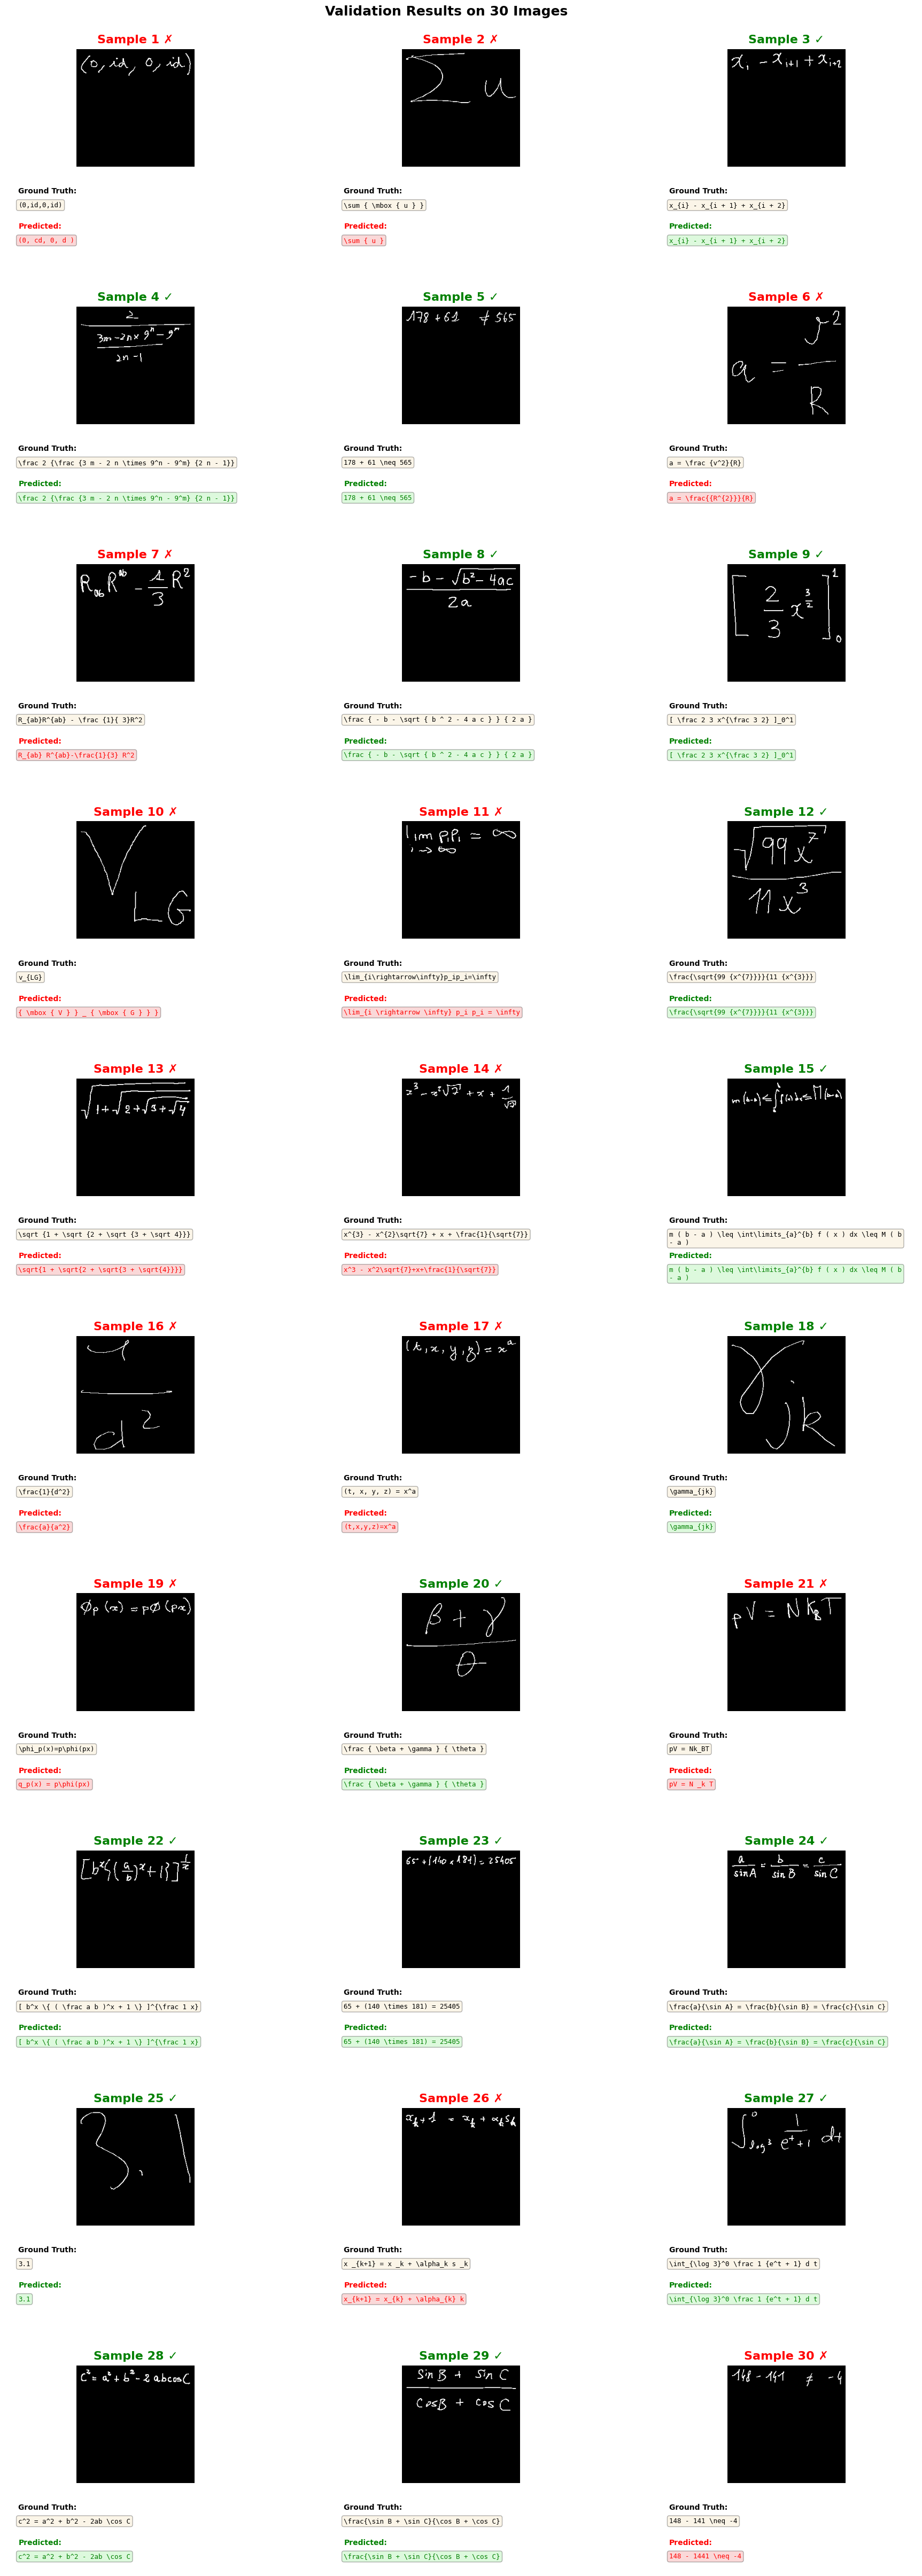


VALIDATION SUMMARY - 30 Samples
Sample  1: ✗  WER: 400.00%
Sample  2: ✗  WER: 42.86%
Sample  3: ✓  EXACT MATCH
Sample  4: ✓  EXACT MATCH
Sample  5: ✓  EXACT MATCH
Sample  6: ✗  WER: 25.00%
Sample  7: ✗  WER: 40.00%
Sample  8: ✓  EXACT MATCH
Sample  9: ✓  EXACT MATCH
Sample 10: ✗  WER: 1300.00%
Sample 11: ✗  WER: 600.00%
Sample 12: ✓  EXACT MATCH
Sample 13: ✗  WER: 36.36%
Sample 14: ✗  WER: 57.14%
Sample 15: ✓  EXACT MATCH
Sample 16: ✗  WER: 0.00%
Sample 17: ✗  WER: 83.33%
Sample 18: ✓  EXACT MATCH
Sample 19: ✗  WER: 200.00%
Sample 20: ✓  EXACT MATCH
Sample 21: ✗  WER: 66.67%
Sample 22: ✓  EXACT MATCH
Sample 23: ✓  EXACT MATCH
Sample 24: ✓  EXACT MATCH
Sample 25: ✓  EXACT MATCH
Sample 26: ✗  WER: 44.44%
Sample 27: ✓  EXACT MATCH
Sample 28: ✓  EXACT MATCH
Sample 29: ✓  EXACT MATCH
Sample 30: ✗  WER: 0.00%
Expression Recognition Rate (EXP): 60.00% (16/30)
Word Error Rate (WER): 23.81%



In [ ]:
# Test inference with visual display - Compact Grid Layout
model.eval()
num_samples = 30
cols = 3
rows = (num_samples + cols - 1) // cols

# Compact figure with less spacing
fig = plt.figure(figsize=(22, 5.5 * rows))
gs = fig.add_gridspec(rows * 3, cols, hspace=0.25, wspace=0.25, height_ratios=[2, 1.2, 0.3] * rows)

# Store results for metrics calculation
results = []

with torch.no_grad():
    for idx in range(min(num_samples, len(test_dataset))):
        # Get sample
        image, target, target_length = test_dataset[idx]

        # Add batch dimension and predict
        image_input = image.unsqueeze(0).to(device)
        outputs = model.beam_search(
            image_input,
            beam_size=BEAM_SIZE,
            max_length=MAX_SEQ_LENGTH,
            sos_id=vocab.sos_id,
            eos_id=vocab.eos_id,
            pad_id=vocab.pad_id,
        )
        prediction = outputs["predictions"][0].cpu().tolist()

        # Decode
        predicted_latex = vocab.decode(prediction, remove_special=True)
        target_latex = vocab.decode(target.tolist(), remove_special=True)
        match = predicted_latex == target_latex

        # Store for metrics
        results.append((target_latex, predicted_latex))

        # Calculate grid position
        row = idx // cols
        col = idx % cols

        # TOP: Display image
        ax_img = fig.add_subplot(gs[row * 3, col])
        ax_img.imshow(image[0].cpu().numpy(), cmap="gray")
        ax_img.axis("off")
        color = "green" if match else "red"
        symbol = "✓" if match else "✗"
        ax_img.set_title(f"Sample {idx + 1} {symbol}", fontsize=16, color=color, weight="bold", pad=8)

        # MIDDLE: Display text results
        ax_text = fig.add_subplot(gs[row * 3 + 1, col])
        ax_text.axis("off")

        # Wrap text intelligently
        max_len = 60

        def wrap_text(text, width):
            if len(text) <= width:
                return text
            lines = []
            while len(text) > width:
                break_point = text[:width].rfind(" ")
                if break_point == -1:
                    break_point = width
                lines.append(text[:break_point])
                text = text[break_point:].lstrip()
            lines.append(text)
            return "\n".join(lines)

        target_display = wrap_text(target_latex, max_len)
        pred_display = wrap_text(predicted_latex, max_len)

        # Display with compact spacing
        ax_text.text(
            0.05,
            0.95,
            "Ground Truth:",
            fontsize=10,
            weight="bold",
            verticalalignment="top",
        )
        ax_text.text(
            0.05,
            0.75,
            target_display,
            fontsize=9,
            verticalalignment="top",
            family="monospace",
            bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.3),
        )
        ax_text.text(
            0.05,
            0.45,
            "Predicted:",
            fontsize=10,
            weight="bold",
            verticalalignment="top",
            color=color,
        )
        ax_text.text(
            0.05,
            0.25,
            pred_display,
            fontsize=9,
            verticalalignment="top",
            family="monospace",
            color=color,
            bbox=dict(boxstyle="round", facecolor="lightgreen" if match else "lightcoral", alpha=0.3),
        )
        ax_text.set_xlim(0, 1)
        ax_text.set_ylim(0, 1)

plt.suptitle(f"Validation Results on {num_samples} Images", fontsize=18, weight="bold", y=0.995)
plt.subplots_adjust(top=0.98)
plt.show()

# Prepare data for metrics calculation
all_predictions = []
all_targets = []

for target, predicted in results:
    # Convert strings back to token lists for the existing compute_wer function
    pred_tokens = [vocab.token2id.get(token, vocab.unk_id) for token in predicted.split()]
    tgt_tokens = [vocab.token2id.get(token, vocab.unk_id) for token in target.split()]
    all_predictions.append(pred_tokens)
    all_targets.append(tgt_tokens)

# Use existing compute_wer and compute_exprate functions
wer_result = compute_wer(all_predictions, all_targets, pad_id=vocab.pad_id)
exprate = compute_exprate(all_predictions, all_targets, pad_id=vocab.pad_id)

# Count exact matches for display
exact_matches = sum(1 for target, predicted in results if target == predicted)

# Print detailed summary with metrics
print(f"\n{'=' * 90}")
print(f"VALIDATION SUMMARY - {num_samples} Samples")
print(f"{'=' * 90}")

for idx, (target, predicted) in enumerate(results):
    match = target == predicted

    if match:
        print(f"Sample {idx + 1:2d}: ✓  EXACT MATCH")
    else:
        # Calculate individual WER for this sample
        pred_tokens = [vocab.token2id.get(token, vocab.unk_id) for token in predicted.split()]
        tgt_tokens = [vocab.token2id.get(token, vocab.unk_id) for token in target.split()]
        distance = editdistance.eval(pred_tokens, tgt_tokens)
        sample_wer = (distance / len(tgt_tokens) * 100) if len(tgt_tokens) > 0 else 0
        print(f"Sample {idx + 1:2d}: ✗  WER: {sample_wer:.2f}%")

print(f"{'=' * 90}")
print(f"Expression Recognition Rate (EXP): {exprate:.2f}% ({exact_matches}/{num_samples})")
print(f"Word Error Rate (WER): {wer_result['wer']:.2f}%")
print(f"{'=' * 90}\n")

## Bibliografia

**[1]** H. Mouchère, "ICFHR 2016 Competition on Recognition of On-line Handwritten Mathematical Expressions (ICFHR-CROHME-2016)," TC11 Online Resources, 2016. [Online]. Disponível em: https://tc11.cvc.uab.es/datasets/ICFHR-CROHME-2016_1

**[2]** J. Zhang, J. Du, S. Zhang, D. Liu, Y. Hu, J. Hu, S. Wei, and L. Dai, "Watch, attend and parse: An end-to-end neural network based approach to handwritten mathematical expression recognition," *Pattern Recognition*, vol. 71, pp. 196–206, Nov. 2017, doi: 10.1016/j.patcog.2017.06.013. Disponível em: https://doi.org/10.1016/j.patcog.2017.06.017

---

### Datasets Processados

**CROHME Todos os Anos (9 canais)** - Dataset combinado do CROHME 2011-2016 com imagens de 9 canais (escala de cinza + 8 características direcionais), divisão treino/teste 90/10 (13.259 treino + 1.474 teste). [Online]. Disponível em: https://drive.google.com/file/d/15jHjoiMB_sscxbzIjltbD4403DvcrK0B/view?usp=sharing

**CROHME 2012 (9 canais)** - Dataset CROHME 2012 com imagens de 9 canais, divisão original da competição (1.338 treino + 488 teste). [Online]. Disponível em: https://drive.google.com/file/d/1V07hXvza5CW4Rfm3MLMO4zAgP5CBo_OT/view?usp=sharing